# Selección de clientes HybridFL - Método basado en recursos

En este notebook vamos a entrenar un modelo de ML utilizando el paradigma de Aprendizaje Federado [1] para los problemas de clasificación de dígitos manuscritos MNIST [2] y clasificación de imágenes a color CIFAR-10 [3]. Usaremos estos dos problemas de visión por computador para la implementación y análisis de rendimiento del método de selección de clientes basado en recursos HybridFL [4].
> [1] https://arxiv.org/abs/1602.05629
>
> [2] http://yann.lecun.com/exdb/mnist
>
> [3] https://www.cs.toronto.edu/~kriz/cifar.html
>
> [4] https://arxiv.org/abs/1905.07210

In [1]:
# install FLEXible framework if not installed
try:
    import flex
    print("FLEXible is installed.")
except:
    print("FLEXible is not installed.\nInstalling dependency flexible-fl...")
    !pip install flexible-fl

FLEXible is not installed.
Installing dependency flexible-fl...
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 1.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.7/229.7 kB 4.0 MB/s eta 0:00:00a 0:00:01
  Created wheel for cardinality: filename=cardinality-0.1.1-py3-none-any.whl size=2587 sha256=1076650b052608e22a87edd3e1f66f2cb54e9f594fb94fe2fbfa0e70ad163031
  Stored in directory: /root/.cache/pip/wheels/b8/19/d1/2665c004b583a7d1880fa59055a3e462d6e35841a01b57010b
Successfully built cardinality


In [2]:
# install Torchsummary if not installed
try:
    import torchsummary
    print("torchsummary is installed.")
except:
    print("torchsummary is not installed.\nInstalling dependency torchsummary...")
    !pip install torchsummary

torchsummary is not installed.
Installing dependency torchsummary...


In [3]:
import matplotlib.pyplot as plt

def plot_loss_accuracy(loss, accuracy, title="Learning Curves"):
    # Example data
    epochs = range(1, len(loss) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'g', label='Accuracy')
    plt.title("Accuracy over Epochs")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle(title)

    # Show the plots
    plt.tight_layout()
    plt.show()

In [4]:
import torch

# select device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
device

'cuda'

# Cargar datasets - MNIST, CIFAR-10

## Distribución de los datos

Para la distribución de los datos preparamos una federación para ambos datasets en el que simulamos clientes __heterogéneos__ en cuestión tanto de clases como del tamaño de sus conjuntos de datos. Nos basamos en la federación que realizan en [1].

Para poder crear un escenario de clientes heterogéneos, suponemos un dataset de $10$ clases que puede ser cualquiera de los que estamos utilizando (MNIST o CIFAR-10). Luego realizamos una federación con la siguiente descripción de [1]: _"muestrear dos/diez clases para cada cliente para CIFAR-10/CIFAR-100 $^1$; Luego, para cada cliente $i$ y una clase seleccionada $c$, muestreamos $\alpha_{i,c} \sim U(.4, .6)$, y lo asignamos con $\frac{\alpha_{i,c}}{\sum_j{\alpha_{j,c}}}$ de los ejemplos para esta clase. Repetimos lo anterior para $10, 50$ y $100$ clientes."_ De esta forma, creamos una distribución de datos en el que cada cliente tendrán un número de clases diferente al resto y con diferentes tamaños, formando una distribución no-IID de datos.

> $^1$ En nuestro caso solo será para CIFAR-10 y MNIST, es decir, suponemos siempre $10$ clases.
>
> [1] https://arxiv.org/abs/2103.04628.

## MNIST
El primero será MNIST (Modified National Institute of Standards and Technology database), que consiste en imágenes de $28$ pixeles de ancho y alto en escala de grises de dígitos manuscritos del $0$ al $9$. Formalmente, definimos el problema de ML como un problema de clasificación multiclase, donde definimos una imagen de entrada $X_n \in \mathcal X$ se define como una matriz $X_{28\times 28}, x_i \in \{1, ..., 255\}$, donde $x_i$ es un pixel de la imagen $X$. Cada imágen de entrada $X_n\in \mathcal X$ es etiquetada con una clase $y_n \in \mathcal Y, y = \{0, 1, ..., 9\}$ que representa el dígito al que corresponde la imagen. El conjunto de entrenamiento consta de $N=240,000$ imágenes.

El dataset descargado será el de _Extended MNIST_ [1], que comprende una versión extendida del concepto original de MNIST para proporcionar dígitos y letras manuscritas, una cantidad más grande de datos, diferentes formas de separar los datos (solo dígitos, letras, por clase, ...), etc. Nosotros solo utilizaremos los dígitos para entrenar el clásico MNIST, del cual su versión extendida consta de $N = 280,000$ imágenes de dígitos manuscritos.

Para poder federar EMNIST, debemos de crear una configuración con `FedDatasetConfig` para poder especificar como queremos distribuir los datos y a cuántos nodos queremos federarlo y luego utilizar la clase `FedDataDistribution` para poder crear el dataset federado. Definimos también las transformaciones a realizar a los datos que son simplemente normalizar cada pixel a valores de $[0,1]$ (función `ToTensor()`) y normalizar los valores de cada pixel con una media y desviación estándar de $0.5$.

> [1] https://www.nist.gov/itl/products-and-services/emnist-dataset

In [5]:
import math
import numpy as np

from copy import deepcopy
from torchvision import datasets, transforms
from flex.data import Dataset, FedDatasetConfig, FedDataDistribution

K_mnist = 1000

train_data = datasets.MNIST(
    root='.',
    train=True,
    download=True,
    transform=None  # we apply them later in training process
)

test_data = datasets.MNIST(
    root='.',
    train=False,
    download=True,
    transform=None  # we apply them later in training process
)

config = FedDatasetConfig(seed=33)
config.replacement = False
config.n_nodes = K_mnist

# assign a sample proportion for each node-class pair (https://arxiv.org/abs/2404.06127)
num_classes = 10
alphas = np.random.uniform(low=0.4, high=0.6, size=(config.n_nodes, num_classes))
alphas = alphas / np.sum(alphas, axis=0)
config.weights_per_label = alphas

# create Federated data distribution of MNIST
flex_dataset_mnist = FedDataDistribution.from_config(
    centralized_data=Dataset.from_torchvision_dataset(train_data), config=config
)

# assign test data to server_id
server_id = "server"
flex_dataset_mnist[server_id] = Dataset.from_torchvision_dataset(test_data)

# apply transforms
mnist_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 31907634.25it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 952811.53it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 8996094.26it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2367701.81it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



## CIFAR-10

El segundo dataset es CIFAR-10 (_Canadian Institute for Advanced Research_)[1], el cual es otro de los datasets junto con MNIST, más utilizados en el campo del Deep Learning y Visión por Computador. CIFAR-10 consiste en una colección de imágenes de $32$ pixeles de altura y de ancho a color ($3$ canales RGB) representando $10$ objetos reales:
- Avión (airplane)
- Automóvil (automobile)
- Pájaro (bird)
- Gato (cat)
- Ciervo (deer)
- Perro (dog)
- Rana (frog)
- Caballo (horse)
- Barco (ship)
- Camión (truck)

Formalmente, definimos el problema de ML como un problema de clasificación multiclase, donde definimos una imagen de entrada $X_n \in \mathcal X$ se define como una matriz $X_{32\times 32 \times 3}, x_i \in \{1, ..., 255\}$, donde $x_i^c$ es un pixel de la imagen $X$ en el canal $c$. Cada imágen de entrada $X_n\in \mathcal X$ es etiquetada con una clase $y_n \in \mathcal Y, y = \{0, 1, ..., 9\}$ tal que indexa la lista de clases $C=(c_0=\text{plane}, c_1=\text{automobile}, ..., c_9=\text{truck})$. El conjunto de entrenamiento consta de $N=50,000$ datos de entrada.

Realizamos la misma serie de operaciones que con EMNIST, para el mismo número de clientes, $K = 1000$ (sin contar el servidor). Definimos también las transformaciones para escalar los valores a $[0,1]$ y normalizar con medias y desviaciones estándar específicas de CIFAR-10 [2].

> [1] https://www.cs.toronto.edu/~kriz/cifar.html
>
> [2] https://github.com/kuangliu/pytorch-cifar/issues/19

In [6]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from flex.data import FedDataDistribution, FedDatasetConfig, Dataset

K_cifar = 1000

train_data = datasets.CIFAR10(
    root=".",
    train=True,
    download=True,
    transform=None,  # we apply them later in training process
)

test_data = datasets.CIFAR10(
    root=".",
    train=False,
    download=True,
    transform=None,  # we apply them later in training process
)

config = FedDatasetConfig(seed=33)
config.replacement = False
config.n_nodes = K_cifar

num_classes = 10

# assign a sample proportion for each node-class pair
alphas = np.random.uniform(low=0.4, high=0.6, size=(config.n_nodes, num_classes))
alphas = alphas / np.sum(alphas, axis=0)
config.weights_per_label = alphas

# create Federated data distribution of CIFAR-10
flex_dataset_cifar = FedDataDistribution.from_config(
    centralized_data=Dataset.from_torchvision_dataset(train_data),
    config=config
)

# assign test data to server_id
server_id = "server"
flex_dataset_cifar[server_id] = Dataset.from_torchvision_dataset(test_data)

# apply transforms
cifar_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # Normalizar con las medias y desviaciones estándar específicas de CIFAR-10
])

100%|██████████| 170498071/170498071 [00:01<00:00, 87215355.94it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


# Modelos de aprendizaje

Definimos dos modelos de Machine Learning, uno para cada uno de los dos datasets que hemos definido anteriormente. Para ambos problemas, usaremos como función de pérdida o _criterion_ la función de entropía cruzada o _Cross Entropy Loss_ cuya definición [1] la define como (para una muestra $n$):

$$l_n = -w_{y_n} \cdot \log \frac{\exp (x_n, y_n)}{\sum_{c=0}^C \exp (x_n, c)} =-w_{y_n}\cdot \log (\text{Softmax} (x_n, y_n))$$

En ambos problemas utilizaremos Adam [2] como optimizador o algoritmo de aprendizaje. Utilizaremos los mismos parámetros que en [2] al haber hecho los experimentos sobre modelos similares y con los mismos datasets que estamos usando y que han demostrando buenos resultados: $\eta = 0.01$ y $\beta_1 = 0.9,\beta_2 = 0.999$. Estos parámetros están definidos por defecto en la librería de PyTorch [3].

> [1] https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
>
> [2] https://arxiv.org/abs/1412.6980
>
> [3] https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

---




## Perceptrón Multicapa (MNIST)

El primero, que lo usaremos para ajustar MNIST, será un Perceptrón Multicapa (MLP) de dos capas ocultas de $128$ unidades la primera y $10$ la segunda (correspondiente al número de clases), y usando ReLU [1] como función de activación.

El modelo inicialmente lo tendrá el servidor y será copiado a cada uno de los clientes. En FLEX usamos el decorador `@init_model_server` para inicializar el modelo en el servidor, donde también podemos además de nuestra arquitectura del modelo, el optimizador y la función de pérdida a usar.

> [1] https://en.wikipedia.org/wiki/Rectifier_(neural_networks)

In [7]:
from typing import Tuple

import torch.nn as nn
import torch.nn.functional as F


class MLP(nn.Module):
    """
    Multi-layer Perceptron classifier with two hidden layers.
    """
    def __init__(self, in_features: Tuple[int, int], hidden_features: int, num_classes: int = 10):
        super().__init__()

        width, height = in_features

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(width * height, hidden_features)
        self.fc2 = nn.Linear(hidden_features, num_classes)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        return x

In [8]:
import torchsummary

torchsummary.summary(MLP((28, 28), 128).to(device), (1, 28, 28), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
            Linear-3                   [-1, 10]           1,290
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.39
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


## Red Neuronal Convolucional (CNN) - CIFAR-10

Para nuestro segundo problema, que consta de ajustar un modelo para clasificar CIFAR-10, utilizaremos un red neuronal convolucional o CNN. A diferencia de MNIST, CIFAR-10 tiene unos datos de entrada con una dimensionalidad más compleja, por lo que utilizar una CNN reduciría la cantidad de parámetros necesarios a entrenar.

Usaremos la red neuronal convolucional usada en la configuración experimental de HybridFL, que consiste en una CNN estándar que consiste en _"seis capas de convolución de 3 × 3 (con 32, 32, 64, 64, 128 y 128 canales, cada una de las cuales se activaba utilizando ReLU y se normalizaba por lotes, y cada dos de las cuales estaban seguidas de un max pooling de 2 × 2), seguidas de tres capas completamente conectadas (con 512 y 192 unidades activadas utilizando ReLU [2] y otras 10 unidades activadas utilizando soft-max)."_ [1].

> [1] https://arxiv.org/abs/1905.0721
>
> [2] https://en.wikipedia.org/wiki/Rectifier_(neural_networks)

In [9]:
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    """
    Convolucional Neural Net classifier for CIFAR-10 image recognition (32x32 images).

    Model architecture taken from HybridFL experimental setting:
    - https://arxiv.org/abs/1905.07210
    """
    def __init__(self, in_channels: int, in_width: int = 32, in_height: int = 32, output_dim: int = 10):
        super(CNN, self).__init__()

        self.in_channels = in_channels
        self.input_w = in_width
        self.input_h = in_height
        self.num_classes = output_dim

        # Pooling Layer (applied every two layers)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # First layer
        self.conv1 = nn.Conv2d(in_channels=self.in_channels, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        output_w_1, output_h_1 = self.__conv_output_dims(
            self.input_w, self.input_h, 3, 1
        )

        # Second layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        output_w_2, output_h_2 = self.__conv_output_dims(
            output_w_1, output_h_1, 3, 1
        )

        # after pooling
        output_w_2, output_h_2 = self.__pool_output_dims(
            output_w_2, output_h_2, 2, 2
        )

        # Third layer
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        output_w_3, output_h_3 = self.__conv_output_dims(
            output_w_2, output_h_2, 3, 1
        )

        # Fourth layer
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)

        output_w_4, output_h_4 = self.__conv_output_dims(
            output_w_3, output_h_3, 3, 1
        )

        # after pooling
        output_w_4, output_h_4 = self.__pool_output_dims(
            output_w_4, output_h_4, 2, 2
        )

        # Fifth layer
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)

        output_w_5, output_h_5 = self.__conv_output_dims(
            output_w_4, output_h_4, 3, 1
        )

        # Sixth layer
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)

        output_w_6, output_h_6 = self.__conv_output_dims(
            output_w_5, output_h_5, 3, 1
        )

        # after pooling
        output_w_6, output_h_6 = self.__pool_output_dims(
            output_w_6, output_h_6, 2, 2
        )

        # Fully-Connected layer
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=int(output_w_6 * output_h_6 * 128), out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=self.num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(F.relu(self.bn6(self.conv6(x))))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # softmax applied on loss function
        return x

    def __conv_output_dims(self, width: int, height: int, kernel_size: int, padding: int = 1):
        output_w = width - kernel_size + 2 * padding + 1
        output_h = height - kernel_size + 2 * padding + 1
        return output_w, output_h

    def __pool_output_dims(self, width: int, height: int, kernel_size: int, stride: int = 1):
        output_w = np.floor((width - kernel_size) / stride) + 1
        output_h = np.floor((height - kernel_size) / stride) + 1

        return output_w, output_h

In [10]:
torchsummary.summary(CNN(in_channels=3, output_dim=10).to(device), (3, 32, 32), device=str(device))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,248
       BatchNorm2d-4           [-1, 32, 32, 32]              64
         MaxPool2d-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          18,496
       BatchNorm2d-7           [-1, 64, 16, 16]             128
            Conv2d-8           [-1, 64, 16, 16]          36,928
       BatchNorm2d-9           [-1, 64, 16, 16]             128
        MaxPool2d-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 128, 8, 8]          73,856
      BatchNorm2d-12            [-1, 128, 8, 8]             256
           Conv2d-13            [-1, 128, 8, 8]         147,584
      BatchNorm2d-14            [-1, 12

# Configuración básica de escenario de FL

Configuraremos un escenario de aprendizaje federado centralizado (CFL) usando la librería FLEXible. FLEXible [1], o simplemente FLEX, es una librería de Python que proporciona un framework para la construcción de entornos de aprendizaje federado para fines de investigación y simulación. FLEX pretende dar flexibilidad en cuanto la gran variedad de escenarios y necesidades que se pueden llegar a plantear para experimentar en entornos federados.

Uno de nuestros objetivos es _integrar_ un método o técnica de selección de clientes en un escenario inicial de FL. La flexibilidad de FLEX nos permitirá conseguir este objetivo gracias a su flujo de mensajes entre entidades separadas por roles, y por la arquitectura modular de estas que nos permiten almacenar información de manera conveniente [1].

> [1] https://arxiv.org/abs/2404.06127
---

## Inicialización del modelo del servidor

El primer paso de nuestro bucle de entrenamiento en aprendizaje federado es inicializar el modelo FLEX del servidor (que posteriormente se distribuirá a los clientes).

Con FLEX podemos hacer uso del decorador `init_server_model` para facilitarnos esta tarea. Esta función entonces debe de instanciar y devolver un modelo de FLEX en donde además definimos el modelo de aprendizaje $^1$, la función de pérdida, el optimizador y cualquier otra información que se usará en las demás fases de la ronda de entrenamiento.

Definimos dos funciones que realizan esta tarea, dos para cada una de nuestras arquitecturas, el Perceptrón Multicapa y la Red Neuronal Convolucional. Como habíamos especificado en el planteamiento del problema de ML a resolver, utilizaremos el optimizador SGD-Adam con sus parámetros por defecto, y la Cross-Entropy como función de pérdida.

> $^1$ No se debe confundir el modelo de tipo `FlexModel` con un modelo de ML. El primero implementa el bloque fundamental que define una entidad en el escenario de FL (donde almacenamos información, sus datos locales, su modelo de aprendizaje, ...). El segundo es un modelo aprendizaje como lo puede ser un módulo de PyTorch o Tensorflow que realiza el aprendizaje automático y la predicción sobre los datos. Se dejará claro la diferencia entre los dos tipos de modelos.


In [11]:
import torch.nn as nn
import torch.nn.functional as F

from flex.pool import init_server_model
from flex.pool import FlexPool
from flex.model import FlexModel

mnist_in_features = (28, 28)
mnist_hidden_features = 128

@init_server_model
def build_server_model_mlp():
    server_flex_model = FlexModel()

    server_flex_model["model"] = MLP(mnist_in_features, mnist_hidden_features)

    # Required to store this for later stages of the FL training process
    server_flex_model["criterion"] = torch.nn.CrossEntropyLoss()
    server_flex_model["optimizer_func"] = torch.optim.Adam
    server_flex_model["optimizer_kwargs"] = {}
    return server_flex_model

cifar_in_channels = 3
cifar_num_classes = 10

@init_server_model
def build_server_model_cnn():
    server_flex_model = FlexModel()

    server_flex_model["model"] = CNN(in_channels=cifar_in_channels, output_dim=cifar_num_classes)

    # Required to store this for later stages of the FL training process
    server_flex_model["criterion"] = torch.nn.CrossEntropyLoss()
    server_flex_model["optimizer_func"] = torch.optim.Adam
    server_flex_model["optimizer_kwargs"] = {}
    return server_flex_model

---
## Distribuir modelo del servidor

El siguiente paso a realizar en un flujo de entrenamiento de aprendizaje federado es la distribución del modelo del servidor a los cientes. Con FLEX, podemos utilizar el decorador `@deploy_server_model` para distribuir el modelo del servidor a los clientes, definiendo una función que devuelva el modelo a almacenar en cada cliente.

En este caso, realizamos una copia profunda del modelo del servidor que será asignado a cada cliente.


In [12]:
from flex.pool import deploy_server_model
import copy


@deploy_server_model
def copy_server_model_to_clients(server_flex_model: FlexModel):
    print(server_flex_model.keys())
    return copy.deepcopy(server_flex_model)

## Actualización del modelo del lado del cliente

Definimos la función encargada de realizar el entrenamiento del modelo sobre los datos locales del cliente. A esta función, es conveniente pasarle como parámetros los hiperparámetros de entrenamiento de un modelo de ML convencional como el número de épocas $E$ y el tamaño de _batch_ $B$

In [13]:
from flex.data import Dataset
from torch.utils.data import DataLoader


def train(client_flex_model: FlexModel, client_data: Dataset, **kwargs):
    # parse kwargs
    epochs = kwargs["epochs"] if "epochs" in kwargs else 5
    batch_size = kwargs["batch_size"] if "batch_size" in kwargs else 20
    transforms = kwargs["transforms"] if "transforms" in kwargs else None

    # get client data as a torchvision object
    train_dataset = client_data.to_torchvision_dataset(transform=transforms)
    client_dataloader = DataLoader(train_dataset, batch_size=batch_size)

    # get model
    model = client_flex_model["model"]
    optimizer = client_flex_model["optimizer_func"](
        model.parameters(), **client_flex_model["optimizer_kwargs"]
    )
    model = model.train()
    model = model.to(device)
    criterion = client_flex_model["criterion"]

    # train model
    for _ in range(epochs):
        for imgs, labels in client_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            pred = model(imgs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()


## Obtener los parámetros de los clientes

Ahora implementamos la función que hace que el servidor (con rol de agregador) recupere los nuevos parámetros actualizados de los clientes. Con el decorador `@collect_clients_weights` recuperamos los pesos de PyTorch de cada cliente seleccionado para esa ronda. En el caso de PyTorch, el modelo devuelve los pesos en forma de un diccionario con `state_dict` para el que cada nombre representa una capa de la red y sus parámetros, lo que hacemos será devolver una lista con los valores de ese diccionario correspondientes a los pesos de la red entera.

In [14]:
from flex.pool import collect_clients_weights


@collect_clients_weights
def get_clients_weights(client_flex_model: FlexModel):
    weight_dict = client_flex_model["model"].state_dict()
    return [weight_dict[name] for name in weight_dict]

## Agregación de los parámetros

El servidor/agregador agrega entonces estos nuevos parámetros para conseguir el nuevo modelo global. Utilizamos el decorador `@aggregate_weights` para poder agregar los pesos que hemos recuperado de los clientes en la fase anterior computando la media de los pesos de manera uniforme, conocido como agregador FedAvg [1], donde realizamos la media por columnas para cada capa de pesos.

> [1] https://arxiv.org/abs/1602.05629

In [15]:
from flex.pool import aggregate_weights
import tensorly as tl

tl.set_backend("pytorch")


@aggregate_weights
def aggregate_with_fedavg(list_of_weights: list):
    agg_weights = []
    for layer_index in range(len(list_of_weights[0])):
        weights_per_layer = [weights[layer_index] for weights in list_of_weights]
        weights_per_layer = tl.stack(weights_per_layer)
        weights_per_layer = weights_per_layer.clone().detach().float().requires_grad_(True)   # ensure is floating-point type
        agg_layer = tl.mean(weights_per_layer, axis=0)
        agg_weights.append(agg_layer)
    return agg_weights

Finalmente, agregamos los pesos al modelo de nuestro servidor/agregador. Sencillamente, para cada capa de nuestro modelo, realizamo una copia del nuevo que hemos agregado en la fase anterior.

In [16]:
from flex.pool import set_aggregated_weights


@set_aggregated_weights
def set_agreggated_weights_to_server(server_flex_model: FlexModel, aggregated_weights):
    with torch.no_grad():
        weight_dict = server_flex_model["model"].state_dict()
        for layer_key, new in zip(weight_dict, aggregated_weights):
            weight_dict[layer_key].copy_(new)

## Evaluación del modelo global

Podemos evaluar el modelo del servidor sobre el dataset de test que hemos definido anteriormente que residía en el mismo servidor. Para ello, definimos una función `evaluate_global_model` que obtenga las predicciones del modelo con el dataset de test y devuelva las metricas resultantes, que en este caso son simplemente la pérdida y la _accuracy_.

In [17]:
def evaluate_global_model(server_flex_model: FlexModel, test_data: Dataset):
    model = server_flex_model["model"]
    model.eval()
    test_loss = 0
    test_acc = 0
    total_count = 0
    model = model.to(device)
    criterion = server_flex_model["criterion"]
    # get test data as a torchvision object
    test_dataset = test_data.to_torchvision_dataset(transform=mnist_transforms)
    test_dataloader = DataLoader(
        test_dataset, batch_size=256, shuffle=True, pin_memory=False
    )
    losses = []
    with torch.no_grad():
        for data, target in test_dataloader:
            total_count += target.size(0)
            data, target = data.to(device), target.to(device)
            output = model(data)
            losses.append(criterion(output, target).item())
            pred = output.data.max(1, keepdim=True)[1]
            test_acc += pred.eq(target.data.view_as(pred)).long().cpu().sum().item()

    test_loss = sum(losses) / len(losses)
    test_acc /= total_count
    return test_loss, test_acc

## Training loop

A continuación se muestra el bucle de entrenamiento aplicando todas las fases que hemos implementado anteriormente. En esta versión básica se implementa una selección aleatoria (RandomSampling), similar a la propuesta en [1] donde se selecciona de manera aleatoria y uniforme $M$ clientes para la ronda actual. Este proceso se repite de forma iterativa un número determinado de rondas.

In [18]:
from typing import Literal

Problem = Literal["mnist", "cifar"]

def train_n_rounds(pool: FlexPool, n_rounds: int, clients_per_round=20, problem: Problem = "mnist"):
    """
    FL training loop for a certain number of rounds and clients selected.
    """
    # select transformations depending on problem to solve
    transforms = mnist_transforms if problem == "mnist" else cifar_transforms

    losses = []
    accuracies = []
    for i in range(n_rounds):
        print(f"\nRunning round: {i+1} of {n_rounds}")
        selected_clients_pool = pool.clients.select(clients_per_round)
        selected_clients = selected_clients_pool.clients
        print(f"Selected clients for this round: {len(selected_clients)}")
        # Deploy the server model to the selected clients
        pool.servers.map(copy_server_model_to_clients, selected_clients)
        # Each selected client trains her model
        selected_clients.map(train, transforms=transforms)
        # The aggregador collects weights from the selected clients and aggregates them
        pool.aggregators.map(get_clients_weights, selected_clients)
        pool.aggregators.map(aggregate_with_fedavg)
        # The aggregator send its aggregated weights to the server
        pool.aggregators.map(set_agreggated_weights_to_server, pool.servers)
        metrics = pool.servers.map(evaluate_global_model)
        loss, acc = metrics[0]
        losses.append(loss)
        accuracies.append(acc)
        print(f"Server: Test acc: {acc:.4f}, test loss: {loss:.4f}")

    return losses, accuracies

# Selección de clientes con HybridFL

Ahora vamos a adaptar nuestro entorno de aprendizaje federado para utilizar el método de selección de clientes HybridFL [1].

HybridFL, así como otros algoritmos basados en recursos como FedCS [2] (del cual éste y muchos otros se basan), necesitan ser testeados bajo un entorno experimental que simule de forma realista y adecuada los requisitos de tiempo de reloj de cada una de las fases en aprendizaje federado. Tanto HybridFL como FedCS simulan cada uno de estos tiempos en un entorno dedicado de _Mobile Edge Computing_ (MEC) en el que hay un servidor central, denominado _Parameter Server_ o PS, una estación base o BS (que sirve de servidor en el eje o _edge server_), y una red de dispositivos móviles. En nuestro caso, podemos simular este entorno simplemente haciendo que las fases de entrenamiento como de subida de datos sean "agendadas" (_scheduled_), de manera que cumplan un cierto tiempo de reloj determinado antes de completarse. De esta manera, se verá reflejado el impacto que tendrá la estrategia de selección mediante la estimación de estos recursos.

---


## Inicialización de los recursos de los clientes

El siguiente paso para construir este entorno de simulación es determinar los recursos iniciales que tendrán los clientes. Los clientes son en esencia dispositivos (e.g. móviles, coches inteligentes, SmartTVs, ...) que tienen ciertas especificaciones que definen los recursos que posee. HybridFL así como FedCS, consideran dos tipos de recursos en los dispositivos:

- Recursos de comunicación inalámbrica: que influye directamente en la comunicación entre el servidor y los clientes (e.g ancho de banda en red, congestión de la red, _Resource Blocks_ $^1$). Podemos determinar la capacidad de comunicación de los clientes con el servidor en __cuánta cantidad de información es capaz de enviar en un segundo__, a lo que también se le conoce como _throughput_, y utilizamos como unidades estándar Mbit/s.

- Recursos computacionales: que influye en las actualizaciones del modelo en los clientes. HybridFL implementa el concepto de entrenamiento centralizado en el servidor; por tanto, como una suposición estándar en FL, suponemos que el servidor central tiene suficiente potencia computacional como para sobrepasar a los clientes en velocidad por la existencia de _stragglers_ [4]. Por lo que el tiempo de actualización de reloj del servidor la suponemos __nula o despreciable__. Podemos determinar la capacidad computacional de los clientes como __el número de ejemplos que puede procesar en un segundo__ actualizar el modelo [1].

- Permiso de subida de datos: este tipo de recurso, propio de HybridFL, es básicamente el permiso del cliente de subir sus datos al servidor, cuyo número de clientes se asume muy pequeño (menos del $\%1$ como mínimo [1]).
Por tanto, para poder muestrear en cada ronda de FL los recursos de los clientes, inicializamos primero las capacidades computacionales y de comunicación medias de cada cliente, de manera que en cada ronda se puedan samplear con una distribución Gaussiana truncada [5] como lo hacen los autores en [1]. Concretamente, el _throughput_ medio de los clientes se ha extraído de los experimentos hechos en un entorno simulado de comunicaciones inalámbricas de [1], en el que concluyeron que los clientes presentaban un _throughput_ de $\theta^{\text{avg}}_{k} = 1.4$ Mbit/s de media y un máximo de hasta $8.6$ Mbit/s, que resultan valores realistas en una red LTE. En cuanto a la capacidad computacional, se muestrea el número de datos procesados por segundo en entrenamiento de una distribución uniforme $\gamma^{\text{avg}}_{k} \sim U(10, 100)$. Finalmente, se elige de forma aleatoria y uniforme si el cliente $k$ permite su subida de datos en un ratio de $r_{\text{UL}} = 0.01$.

> $^1$ Aunque el número de bloques de recursos o RBs (la unidad mínima de ancho de banda en LTE [3]) puede influir significativamente en el tiempo de comunicación entre el servidor y los clientes, seguiremos la suposición de [2] por el que los RBs asignados a cada cliente son los mismos para todos, de esta manera solo nos preocupan factores más fluctuantes en casos reales como el ancho de banda.
>
> [1] https://arxiv.org/abs/1905.07210
>
> [2] https://arxiv.org/abs/1804.08333
>
> [3] _S. Sesia, M. Baker, and I. Toufik, LTE-the UMTS Long Term Evolution: From Theory to Practice. John Wiley & Sons, 2011_
>
> [4] G. Wang, C. Zhao, Q. Qi, R. Han, L. Bai and J. Choi, "Efficient Federated Learning via Joint Communication and Computation Optimization," in IEEE Transactions on Vehicular Technology, doi: 10.1109/TVT.2024.3379742.
>
> [5] https://en.wikipedia.org/wiki/Truncated_normal_distribution

In [19]:
from copy import deepcopy

# ratio of clients that permit their data to be uploaded
DEFAULT_R_UPLOAD = 0.01

# realistic client average throughput in Mbit/s
AVG_THROUGHPUT = 1.4

def init_client_resources(client_flex_model: FlexModel, client_data: Dataset, **kwargs):
    # parse arguments
    r_upload = kwargs["r_upload"] if "r_upload" in kwargs else DEFAULT_R_UPLOAD

    ## Computation capability - data samples per second
    avg_comp = np.random.uniform(10, 100)

    ## Communication capability - Mbit per second
    avg_thr = AVG_THROUGHPUT

    # client permits data upload
    data_upload = np.random.rand() < r_upload

    client_flex_model["avg_thr"] = avg_thr
    client_flex_model["avg_comp"] = avg_comp
    client_flex_model["data_upload"] = data_upload

    # save Nk
    client_flex_model["n_samples"] = len(client_data)

    # save amount of data for each class
    labels = client_data.to_numpy()[1]
    unique, counts = np.unique(labels, return_counts=True)
    client_flex_model["n_samples_per_class"] = dict(zip(unique, counts))

    # if client permit data to be uploaded, make their dataset public
    if data_upload:
        client_flex_model["public_data"] = client_data

## Petición de recursos

A continuación, implementamos la función `resource_request` en la que el servidor/agregador comunica a $\lceil K \times C \rceil$ clientes (siendo $K$ el total de clientes y $C$ la fracción de clientes a seleccionar por ronda) seleccionados aleatoriamente, a notificarle de los recursos que poseen para la ronda actual, así como notificarle si permiten su subida de datos al servidor. Esta tarea se realizará de la siguiente manera:

1. El servidor inicializará en su modelo de FLEX, un diccionario para cada recurso e información adicional, en el que las claves de los mismos será el identificador del cliente en cuestión.
2. Para cada cliente, se recuperará los valores medios de las capacidades computacionales (el número de ejemplos procesados por unidad de tiempo) y de comunicación (_throughput_), así como también si permiten su subida de los datos.
    - Con esta información, para el cliente en cuestión, se muestrea la capacidad computacional y de comunicación para la ronda actual de una distribución normal truncada (usamos la librería de `scipy` [1] para muestrear aleatoriamente de esta distribución) con los valores medios recuperados de los clientes $^1$. Para el muestreo de la distribución normal truncada se usa una variancia para ambos tipos de recursos de $r_{\text{var}} = 0.2$.
    - Finalmente, con los recursos muestreados para la ronda actual, se pueden calcular los tiempos estimados de actualización y subida: $t^{\text{UL}}_k$ y $t^{\text{UD}}_k$ respectivamente. Que se usarán tanto para la selección de clientes y de datos como para el entrenamiento y subida de modelos agendados.

Definimos además una función `get_model_size` que calcula el tamaño en bytes de un modelo de aprendizaje. Esto nos servirá para estimar el tiempo que tarda un cliente con cierto _throughput_ en subir un modelo mediante la siguiente formula:
$$t_{k}^{\text{UL}} = D_m / \theta_k^{(t)}$$

siendo $D_m$ el tamaño en Mbit del modelo, y $\theta_k^{(t)}$ el _throughput_ del cliente $k$ en la ronda $t$.

El tiempo estimado en actualizar un modelo en un cliente $k$ (i.e. entrenar un modelo) se calcula con la siguiente formula:
$$t_k^{\text{UD}} = \frac{E \times N_k}{\gamma_k^{(t)}}$$

siendo $E$ el número de épocas de entrenamiento, $N_k$ el número de ejemplos que posee el cliente $k$ y $\gamma_k^{(t)}$ el número de ejemplo procesados por unidad de tiempo para entrenar el modelo en el cliente $k$ en la ronda $t$.

> $^1$ Nótese que conceptualmente, este muestreo de la capacidad de comunicación y computacional del cliente es lo que este último realmente notifica al servidor y no sus valores medios.
>
> [1] https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html

In [20]:
import sys
import torch.nn as nn

def get_model_size(model: nn.Module) -> int:
    """
    Get the size in bytes of a PyTorch learning model.
    """
    total_size = 0
    for param in model.parameters():
        total_size += param.numel() * param.element_size()

    return int(total_size)

In [21]:
from typing import List
from scipy.stats import truncnorm

# loose for simulated capabilities
r_var = 0.2

def resource_request(agg_model: FlexModel, client_flex_models: List[FlexModel], **kwargs):
    """
    Requests resource capabilities and whether or not they permit their data to
    be uploaded for M selected clients randomly.
    """
    # parse arguments
    epochs = kwargs["epochs"] if "epochs" in kwargs else 5

    # get model size in bytes
    if "model_size" in agg_model.keys():
        model_size = agg_model["model_size"]
    else:
        model_size = get_model_size(agg_model["model"])
        print(f"Model Size: {model_size} bytes")

        # store model size in server model
        agg_model["model_size"] = model_size


    # indexed resources for each selected client saved in the aggregator
    agg_model["comp_resources"] = {}
    agg_model["comm_resources"] = {}
    agg_model["client_t_update"] = {}
    agg_model["client_t_upload"] = {}
    agg_model["permit_data_upload"] = {}
    agg_model["client_data"] = {}
    agg_model["client_n_samples_per_class"] = {}

    for k in client_flex_models:
        # get client average computational and communications capabilities
        avg_comp_cap = client_flex_models[k]["avg_comp"]
        avg_thr = client_flex_models[k]["avg_thr"]
        permit_data_upload = client_flex_models[k]["data_upload"]

        ## Computational capability - data samples processed per second to train
        std_dev_comp = 0.1 * avg_comp_cap

        # compute lower and upper bounds
        a, b = (1 - r_var) * avg_comp_cap, (1 + r_var) * avg_comp_cap
        a = (a - avg_comp_cap) / std_dev_comp
        b = (b - avg_comp_cap) / std_dev_comp

        comp_cap = truncnorm.rvs(a, b, loc=avg_comp_cap, scale=std_dev_comp, size=1)[0]

        # compute estimated update time
        n_samples = client_flex_models[k]["n_samples"]
        t_update = (epochs * n_samples) / comp_cap

        ## Communication capability - Mbit per second
        std_dev_thr = 0.1 * avg_thr

        # compute lower and upper bounds
        a, b = (1 - r_var) * avg_thr, (1 + r_var) * avg_thr
        a = (a - avg_thr) / std_dev_thr
        b = (b - avg_thr) / std_dev_thr

        comm_cap = truncnorm.rvs(a, b, loc=avg_thr, scale=std_dev_thr, size=1)[0]

        # compute estimated upload time in seconds
        t_upload = (model_size * 8) / (comm_cap * 1_000_000)

        # save resource capabilities for client k in current round
        agg_model["comp_resources"][k] = comp_cap
        agg_model["comm_resources"][k] = comm_cap

        # save estimated update and upload times
        agg_model["client_t_update"][k] = t_update
        agg_model["client_t_upload"][k] = t_upload

        # also save estimated times in clients to simulate scheduled training
        client_flex_models[k]["t_update"] = t_update
        client_flex_models[k]["t_upload"] = t_upload

        ## Client Data
        if permit_data_upload:
            agg_model["client_data"][k] = client_flex_models[k]["public_data"]

        # set data upload permit
        agg_model["permit_data_upload"][k] = permit_data_upload

        ## Amount of data for each class
        agg_model["client_n_samples_per_class"][k] = client_flex_models[k]["n_samples_per_class"]

## Selección de clientes

La selección de los clientes es un algoritmo de tipo _greedy_ en el que se busca maximizar el número de clientes seleccionados $𝕊$ sujeto a un cierto _deadline_ de tiempo por ronda $T_\text{round}$:
$$
\max |𝕊| \\
\text{s.t.} \ T_\text{round} \ge T_\text{cs} + T_{𝕊}^{\text d} + \Theta_{|𝕊|} + T_\text{agg}
$$
siendo $T_\text{cs}$ el tiempo de selección de clientes, $T_{𝕊}^{\text d}$ el tiempo de distribución del modelo global a los clientes seleccionados, $\Theta_{|𝕊|}$ el tiempo transcurrido desde el inicio de la actualización de los modelos hasta que el $k_i$-ésimo cliente haya actualizado y subido sus parámetros al servidor (más información en como se calcula este tiempo en [1]) y $T_\text{agg}$ el tiempo que toma al servidor agregar los parámetros de los clientes.

Como en [1] y [2], nosotros suponemos que el servidor tiene vastos recursos y que por tanto los tiempos de selección y agregación son despreciables: $T_\text{cs} = T_\text{agg} = 0$.

El algoritmo de selección en HybridFL [2] varía del de FedCS [1] en cuanto a que en el primero se elige el cliente con tiempo estimado mínimo mientras que en [1] se elige el que tenga la inversa del tiempo máximo. Como podemos darnos cuenta las dos formas son equivalentes. En nuestro caso optamos por la minimización de la función (i.e. elegir el cliente con menor tiempo estimado agregado). En HybridFL [2], esta función de tiempo transcurrido si se incluye el cliente $k$ al conjunto de seleccionados se le denomina $T_{\text{inc}}(𝕊, k)$.

En [2] además, se elige el cliente con $T_{\text{inc}}$ menor multiplicado por un coeficiente de variación $CV(N_r)$ que penaliza la función a minimizar si los datos de los clientes tienen un alto nivel de desbalance entre clases, de manera que se pueda sanitizar el problema de datos No-IID en los clientes en esa ronda de selección. Mas información sobre como calcular este coeficiente en [2].

> [1] https://arxiv.org/abs/1905.07210
>
> [2] https://arxiv.org/abs/1804.08333

---

Para poder implementar la selección de los clientes, tenemos primero que definir:
1. Por un lado, una función que calcule el tiempo de distribución del modelo a cada cliente.
2. Una función para calcular el tiempo estimado transcurrido si incluimos un cliente $k$ al conjunto de clientes seleccionados $𝕊$, $T_{\text{inc}}(𝕊, k)$.
3. Y por último, una función para calcular el coeficiente de variación $CV(N_r)$.

Definimos $T_\text{round}$ como una variable global para el que se establece como límite de tiempo por ronda de unos $3$ minutos. Se ha elegido este tiempo por mostrar buenos resultados tanto en HybridFL como en FedCS además de ser lo suficientemente corto como para garantizar no agotar todos los clientes, sin embargo, en [1] se deja como una vía de investigación a mejorar el de utilizar un $T_\text{round}$ dinámico.

In [22]:
def T_model_dist(model_size: int, throughputs: list):
    """
    Computes the estimated time it takes to distribute the model to all clients synchronically.

    If throughputs is empty, then time is 0 (no clients to distribute to).
    """
    if not throughputs:
        return 0

    return (model_size * 8) / (min(throughputs) * 1_000_000)

In [23]:
def T_inc(agg_model: FlexModel, S: set, k: int, elapsed_time: int):
    """
    Computes estimate elapsed time when client k is included to selected set of clients S.
    """
    t_upload = agg_model["client_t_upload"][k]
    t_update = agg_model["client_t_update"][k]

    # get model size to estimate dist time
    model_size = agg_model["model_size"]

    # throughputs of clients in S
    S_thr = [agg_model["comm_resources"][client] for client in agg_model["comm_resources"] if client in S]

    # throughputs of clients in S + {k}
    S_plus_k_thr = [agg_model["comm_resources"][client] for client in agg_model["comm_resources"] if client in S or client == k]

    return T_model_dist(model_size, S_plus_k_thr) - T_model_dist(model_size, S_thr) + t_upload + max(0, t_update - elapsed_time)

In [24]:
def CV(agg_model: FlexModel, S: set, classes: list):
    """
    Computes the coefficient of variation of data samples per class in clients in set S.
    """
    # get total number of data samples per class
    Nr = {}
    for k in agg_model["client_n_samples_per_class"]:
        if k not in S:
            continue

        k_counts = agg_model["client_n_samples_per_class"][k]
        Nr = {key: Nr.get(key, 0) + k_counts.get(key, 0) for key in set(Nr) | set(k_counts)}

    # fill up for all classes
    Nr = {key: Nr.get(key, 0) for key in classes}

    L = len(classes)
    n_mean = sum(Nr.values()) / L

    # compute the variance of the amount of data per class
    variance = sum((n_l - n_mean)**2 for n_l in Nr.values()) / L

    # return the coefficient of variance with respect to the mean
    return variance / n_mean

In [25]:
from flex.data import Dataset

T_round = 3 * 60    # 3 minutes

def client_selection(agg_model: FlexModel, agg_data: Dataset):
    # get classes of the ML task
    classes = agg_model["classes"]

    # get client indices
    Kp = set(agg_model["comp_resources"].keys())

    # initialize set of selected clients to train locally
    S = set()

    # initialize time budget
    t = 0

    # function to minimize
    def f(x):
        return T_inc(agg_model, S, x, t)

    while len(Kp) > 0:
        x = min(Kp, key=lambda k: f(k) * CV(agg_model, S | {k}, classes))

        # remove selected from Kp
        Kp.remove(x)

        # check time deadline
        tp = t + T_inc(agg_model, S, x, t)
        if tp < T_round:
            # add client if time deadline is met
            t = tp
            S.add(x)
    
    print("scheduled final time is", t)
    return S

## Selección de datos

En esta fase, el servidor recupera todos los datos de los clientes que permitieron la subida de sus datos $D_u$, y el servidor entonces selecciona los ejemplos según un criterio de selección que depende del _deadline_ $t^\text{UD}$, que es el tiempo decidido para el que cuentan los clientes en subir sus datos antes de que el primer cliente en actualizar el modelo suba sus parámetros. En HybridFL [1], se proponen dos formas de seleccionar los datos que conforman el conjunto de datos final $D^\text{UL}$ para el que el servidor actualiza el modelo global:
1. El primero es seleccionar de manera _greedy_ los ejemplos del cliente con mayor _throughput_ en orden.
2. En el segundo, el servidor intenta construir un conjunto de datos IID de la misma forma que en el primero solo que en vez de hacerlo en orden, lo hace por clase, de manera que se distribuyan los datos de manera idéntica. El dataset $D^\text{UL}$ ya cuenta con la propiedad de ser uniformemente distribuído por haber seleccionado los clientes de forma aleatoria en la fase de __Petición de Recursos__.

> [1] https://arxiv.org/abs/1905.07210

In [39]:
import gc
from flex.data import Dataset

def data_selection(agg_model: FlexModel, agg_data: Dataset, **kwargs):
    S = kwargs["S"]

    # get clients that permit their data to be uploaded and they are not selected to train
    U = [u for u in agg_model["permit_data_upload"] if agg_model["permit_data_upload"][u] and u not in S]

    print(f"Number of clients in U: {len(U)}")

    t_upload_deadline = min(agg_model["client_t_update"].values())
    print("Deadline:", t_upload_deadline)

    classes = agg_model["classes"]

    # masks to skip samples indices from client data
    removal_masks = {u: [] for u in agg_model["client_data"]}

    def client_has_class(k: int, label: int):
        labels = agg_model["client_data"][k].to_numpy()[1]

        # remove already taken samples
        removal_mask = removal_masks[k]
        filtered_classes = np.delete(labels, removal_mask, axis=0)

        res = filtered_classes[filtered_classes == label].size > 0

        return res

    def empty_client_data():
        samples = []
        for u in U:
            d_x, d_y = agg_model["client_data"][u].to_numpy()
            filtered_d_x = np.delete(d_x, removal_masks[u], axis=0)
            filtered_d_y = np.delete(d_y, removal_masks[u], axis=0)
            samples.append(filtered_d_x.size)

        return sum(samples) == 0

    D_ul_X = []
    D_ul_y = []
    flag = True
    t_data_upload = 0

    while flag:
        print("Time upload:", t_data_upload)

        for l in classes:
            # get client with maximum throughput with class l samples
            x = max([u for u in U if client_has_class(u, l)], key=lambda k: agg_model["comm_resources"][k], default=None)

            # if there's no client with l class, just continue with the other class
            if not x:
                # check if there's data before continuing to avoid infinite loop
                flag = not empty_client_data()
                continue

            d_x, d_y = agg_model["client_data"][x].to_numpy()

            # filter data with label l
            mask = np.where(d_y == l)[0].tolist()

            # filter already taken samples
            mask = [i for i in mask if i not in removal_masks[x]]

            # take next first sample of class l
            d = d_x[mask][0]

            # compute data upload time
            u_thr = agg_model["comm_resources"][x]
            D_sample = d.nbytes + np.array(l).nbytes   # size of sample

            t_u = (D_sample * 8) / (u_thr * 1_000_000)

            if (t_data_upload + t_u) <= t_upload_deadline:
                # add d to D_ul
                D_ul_X.append(d)
                D_ul_y.append(l)

                # remove d from D_ul
                removal_masks[x].append(mask[0])

            # check deadline
            if (t_data_upload + t_u) >= t_upload_deadline:
                flag = False

            # finish if clients data are empty
            if empty_client_data():
                flag = False
                break

            # update data upload time
            t_data_upload += t_u
        
        # security check when not found any more data and didn't check deadline
        if t_data_upload >= t_upload_deadline:
            flag = False
        
    return np.array(D_ul_X), np.array(D_ul_y)

## Distribución del modelo global

Redefinimos la subrutina de `copy_server_model_to_clients` visto en la configuración básica, para copiar solo la información que deben de compartir los clientes con el servidor, es decir, no debemos distribuir la información almacenada propia del servidor a los clientes y solo la que nos interesa. Esto viene a darse porque FLEX por defecto copia el modelo del servidor entero, y por tanto se copiaría los datos de los clientes $D_u$, información de los recursos de todos los clientes, etc.

Para solo distribuir la información que nos interesa a los clientes, distribuimos toda la información del servidor para las claves que estén en la lista de claves de distribución (_white list_).

In [27]:
from flex.pool import deploy_server_model
import copy

white_list = [
    "model",
    "criterion",
    "optimizer_func",
    "optimizer_kwargs"
]

@deploy_server_model
def copy_server_model_to_clients(server_flex_model: FlexModel):
    white_listed = {key: value for key, value in server_flex_model.items() if key in white_list}
    return copy.deepcopy(white_listed)

Creamos una subrutina del servidor para poder simular el tiempo de distribución de los modelos a los clientes. Esta función pretende ser ejecutada _luego_ o _antes_ de copiar el servidor del modelo a los clientes.

In [28]:
import time
from tqdm import tqdm
from flex.pool import FlexPool
from flex.data import Dataset

def scheduled_model_distribution(agg_model: FlexModel, _: Dataset, **kwargs):
    # get model size
    model_size = agg_model["model_size"]
    
    # get selected clients
    S: set = kwargs["S"]
    
    # get client throughputs
    thr = [agg_model["comm_resources"][client] for client in agg_model["comm_resources"] if client in S]
    
    # compute Time of Distribution
    t_dist = T_model_dist(model_size, thr)
    
    # simulate Time of Distribution of the model by sleeping
    with tqdm(total=t_dist, desc="Distributing model...") as pbar:
        interval = 0.1
        for _ in range(int(t_dist / interval)):
            time.sleep(interval)
            pbar.update(interval)

## Actualización y subida del modelo agendado

Como hemos explicado anteriormente, para simular el tiempo que se estima en la actualización del modelo en los clientes, definimos la función de entrenamiento `scheduled_train` el cual entrena de la manera convencional que hemos visto en la configuración básica del entorno FL, pero esta vez, el tiempo transcurrido de esta función está sujeto a cumplir el tiempo de actualización para ese cliente como mínimo. De manera que se refleje el impacto de la selección de tal cliente en la duración total del entrenamiento del modelo global.

Los clientes cuando terminan de entrenar su modelo, inmediatamente lo suben al servidor, por lo que también simularemos la subida agendada del modelo actualizado por el cliente en esta función simplemente _durmiendo_ el hilo de ejecución sobre su tiempo de subida $t^{UL}_k$.

In [29]:
import time

def scheduled_train(client_flex_model: FlexModel, client_data: Dataset, **kwargs):
    # parse arguments
    epochs = kwargs["epochs"] if "epochs" in kwargs else 5
    batch_size = kwargs["batch_size"] if "batch_size" in kwargs else 20
    transforms = kwargs["transforms"] if "transforms" in kwargs else None

    # get scheduled update and upload time
    t_update = client_flex_model["t_update"]
    t_upload = client_flex_model["t_upload"]
    
    # start timer
    start = time.time()

    train_dataset = client_data.to_torchvision_dataset(transform=transforms)
    client_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    model = client_flex_model["model"]
    optimizer = client_flex_model["optimizer_func"](
        model.parameters(), **client_flex_model["optimizer_kwargs"]
    )
    model = model.train()
    model = model.to(device)
    criterion = client_flex_model["criterion"]
    for _ in range(epochs):
        for imgs, labels in client_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            pred = model(imgs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

    # stop timer and get effective training time
    end = time.time()
    training_time = end - start

    # simulate scheduled updating and uploading time by sleeping
    time.sleep(max(0, t_update - training_time) + t_upload)

En cuanto a la actualización del modelo de forma centralizada en el servidor con la función `centralized_train`, donde realizamos el mismo bucle de entrenamiento pero en este caso _sin agendar_, debido a que hemos supuesto que el tiempo de entrenamiento del servidor era despreciable comparado con los cliente, y que por tanto no tendría ningún impacto en el tiempo transcurrido de entrenamiento federado. También, ante la posibilidad de que no se haya podido recuperar datos del cliente (e.g. $U = 0$), indicamos con un campo booleano si el servidor ha podido actualizar el modelo o no; para de esta manera saber _a posteriori_ si agregamos los pesos del servidor si y solo si son nuevos parámetros. En cuanto a su tiempo de subida, es evidente que $t^{UL}_\text{server} = 0$ puesto que los parámetros están ya en el servidor.

In [30]:
def centralized_train(server_model: FlexModel, _test_data: Dataset, **kwargs):
    # parse arguments
    epochs = kwargs["epochs"] if "epochs" in kwargs else 5
    batch_size = kwargs["batch_size"] if "batch_size" in kwargs else 20
    transforms = kwargs["transforms"] if "transforms" in kwargs else None

    # get client data
    X, y = kwargs["client_data"]

    if y.size == 0:
        # model has not been updated by server
        server_model["trained"] = False
        return

    client_data = Dataset.from_array(X, y)

    train_dataset = client_data.to_torchvision_dataset(transform=transforms)
    client_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    model = server_model["model"]
    optimizer = server_model["optimizer_func"](
        model.parameters(), **server_model["optimizer_kwargs"]
    )
    model = model.train()
    model = model.to(device)
    criterion = server_model["criterion"]
    for _ in range(epochs):
        for imgs, labels in client_dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            pred = model(imgs)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()

    # server has updated the model
    server_model["trained"] = True

El hilo de ejecución de los clientes se realiza en manera paralela y no secuencial tanto para la actualización de los modelos como su subida. Sin embargo, FedCS (y por tanto HybridFL) establece que las subidas de los modelos se realizan de manera síncrona y secuencial; por tanto, para simular el tiempo que debería durar la actualización y subida de los modelos vamos a definir una función en la que el servidor _duerme_ su hilo de ejecución por el tiempo necesario para simular la actualización paralela y la subida secuencial de los modelos, es decir, el tiempo transcurrido $\Theta_{S_t}$ [1]. En caso de que la ejecución en paralelo haya tomado más tiempo que $\Theta_{S_t}$, simplemente no dormimimos el hilo de ejecución.

> [1] Detalles en cómo calcular $\Theta_{S_t}$ en https://arxiv.org/abs/1804.08333.

In [31]:
import time
from flex.pool import FlexPool
from flex.data import Dataset

def simulate_model_update_upload(server_model: FlexModel, _: Dataset, **kwargs):
    
    # function to compute the time elapsed of clients parallel training and sequential upload
    def compute_simulation_time(S: list, elapsed_time=0):
        k = S[0]
        theta = elapsed_time + server_model["client_t_upload"][k] + max(0, server_model["client_t_update"][k] - elapsed_time)
        
        if len(S) == 1:
            return theta

        return compute_simulation_time(S[1:], elapsed_time=theta)
        
    # get clients indices
    S = list(kwargs["S"])
    
    # get total upload time
    elapsed_training_time = kwargs["training_time"]
    
    # compute the time of sequential model uploads and parallel updates
    sim_time = compute_simulation_time(S)
    
    # sleep for the difference between the parallel and sequential total times
    time_to_sleep = sim_time - elapsed_training_time

    if time_to_sleep > 0:
        time.sleep(time_to_sleep)

## Recolección de las actualizaciones de los modelos

Por último cambiamos la función de obtención y agrupación de los pesos de los clientes para también incluir también los del servidor.

In [32]:
import time
import torch
import numpy as np

def collect_server_and_clients_weights(aggregator_flex_model: FlexModel, clients_flex_models: List[FlexModel], **kwargs):

    def get_model_weights(client_flex_model: FlexModel):
        """
        Returns the weights of a Flex model per layer.
        """
        weight_dict = client_flex_model["model"].state_dict()
        return [weight_dict[name] for name in weight_dict]

    if "weights" not in aggregator_flex_model:
        aggregator_flex_model["weights"] = []
    
    # collect clients weights
    for k in clients_flex_models:
        client_weights = get_model_weights(clients_flex_models[k])
        aggregator_flex_model["weights"].append(client_weights)

    # finally collect server weights if server has trained with client data
    if aggregator_flex_model["trained"]:
        server_weights = get_model_weights(aggregator_flex_model)
        aggregator_flex_model["weights"].append(server_weights)

## Entrenamiento paralelo de los modelos

Cuando no tenemos restricciones de tiempo ni fases agendadas, es viable realizar las actualizaciones locales de los clientes de forma _iterativa_, i.e. una actualización tras de otra. Sin embargo, para poder simular de la manera más cercana a la realidad el entrenamiento en cada ronda y que los resultados sean acordes a partir de los datos y recursos de los clientes, necesitamos hacer que _al menos_ las actualizaciones de los modelos locales en los clientes se realicen de forma paralela. Esto no solo se necesita para obtener resultados coherentes con la configuración establecida, sino que también es necesario para que el entrenamiento sea viable computacionalmente; esto debido a que algunos clientes pueden tomar hasta $> 30$ segundos en actualizar un modelo, algo que puede retrasar el entrenamiento de otro en el caso de hacerse de forma iterativa y síncrona.

Solo necesitaremos de paralelizar las actualizaciones en los clientes. Las demás fases como la subida de los parámetros locales, la distribución del modelo, la agregación de las actualizaciones, etc. Si se han de realizar de forma síncrona. En [1] muestran resultados del estado del arte en aprendizaje distribuído utilizando una aproximación síncrona.

Para entonces poder paralelizar este entrenamiento, creamos una clase `FlexParallelPool` que hereda de la clase de FLEX `FlexPool`. Con esto, definimos un método `parallel_map` que realice la misma tarea que `map` (que es aplicar una función a un conjunto de actores destino), pero en este caso de forma paralela, creando para cada actor destino un hilo de ejecución. De esta manera lograremos paralelizar la función `scheduled_train` de los clientes y así poder simular el entrenamiento en paralelo de una forma más realista.

> [1] https://arxiv.org/abs/1604.00981

In [33]:
import threading
from typing import Callable


class FlexParallelPool(FlexPool):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def parallel_map(self, func: Callable, dst_pool: FlexPool = None, **kwargs):
        if dst_pool is None:
            threads = []
            for i in self._actors:
                t = threading.Thread(target=func, args=(self._models.get(i), self._data.get(i)), kwargs=kwargs)
                threads.append(t)
                t.start()

            for t in threads:
                t.join()

            return None
        elif FlexPool.check_compatibility(self, dst_pool):
            threads = []
            for i in self._actors:
                t = threading.Thread(target=func, args=(self._models.get(i), dst_pool._models), kwargs=kwargs)
                threads.append(t)
                t.start()

            for t in threads:
                t.join()

            return None
        else:
            raise ValueError(
                "Source and destination pools are not allowed to comunicate, ensure that their actors can communicate."
            )

## Training Loop final

Finalmente, implementamos la función de entrenamiento en aprendizaje federado en el que aplicamos todas las funciones que realizan la selección de clientes con HybridFL. Este bucle de entrenamiento recibe un límite de tiempo $T_\text{final}$ para el cual el bucle termina cuando haya transcurrido esta cantidad de tiempo en segundos.

In [34]:
import time
import gc

from flex.pool import FlexPool

MNIST_LABELS = list(set(train_data.targets))
CIFAR_LABELS = list(set(train_data.targets))

def train_n_rounds_hybrid(pool: FlexParallelPool, T_final: int, clients_per_round: int = 100, problem: Problem = "mnist"):
    """
    FL training loop for a certain deadline time in seconds.
    """
    # collect garbage
    gc.collect()

    # save list of classes to server model to use them in client and data selection
    def set_classes_to_server(flex_model: FlexModel, _):
        flex_model["classes"] = MNIST_LABELS if problem == "mnist" else CIFAR_LABELS

    pool.servers.map(set_classes_to_server)

    # select transformations depending on problem to solve and assign to server
    transforms = mnist_transforms if problem == "mnist" else cifar_transforms

    # initialize clients simulated resources
    pool.clients.map(init_client_resources)

    losses = []
    accuracies = []
    elapsed_round_times = []
    total_selected = 0

    start = time.time()
    end = start
    i = 0
    while (end - start) < T_final:
        start_round = time.time()
        print(f"\nRunning round: {i+1} - Time elapsed: {end - start} seconds")

        # Resource Request: ask M random clients to participate in the current round
        # and clients notify the server about their resources and whether or not the permit
        # their data to be uploaded (set U of clients)
        print("Server requesting clients resources...")
        random_clients_pool = pool.clients.select(clients_per_round)
        random_clients = random_clients_pool.clients

        pool.aggregators.map(resource_request, random_clients)

        # Client selection from Kp
        print("Server selecting clients to train locally...")
        S = pool.aggregators.map(client_selection)[0]
        print(f"Selected clients (S): {len(S)} out of {clients_per_round}")

        # Update total selected clients
        total_selected += len(S)

        # Data selection from U clients
        print("Server selecting data to train centralized...")
        client_data = pool.aggregators.map(data_selection, S=S)[0]
        print(f"Selected data length (|D_UL|): {client_data[0].size}")

        # get selected clients pool
        selected_clients_pool = pool.clients.select(lambda actor_id, actor_roles: actor_id in S)
        selected_clients = selected_clients_pool.clients
        print(f"Selected clients for this round: {len(selected_clients)}")

        # Deploy the server model to the selected clients
        print("Distributing model...")
        pool.servers.map(copy_server_model_to_clients, selected_clients)
        # schedule the distribution of the model
        pool.servers.map(scheduled_model_distribution, S=set(S))

        # Each selected client trains their model obeying the time restrictions
        start_update_upload = time.time()
        print("Scheduled model update and upload...")
        FlexParallelPool(selected_clients._data,
                         selected_clients._actors,
                         selected_clients._models).parallel_map(scheduled_train, transforms=transforms)
        end_update_upload = time.time()
        
        # simulate sequential model upload
        pool.servers.map(simulate_model_update_upload, training_time=(end_update_upload - start_update_upload), S=S)
        
        # compute local training time in total
        total_training_time = time.time() - start_update_upload
        print(f"Scheduled model update and upload time: {total_training_time} sec")

        # Server updates model from clients uploaded data
        print("Centralized model update...")
        pool.servers.map(centralized_train, client_data=client_data, transforms=transforms)

        # The aggregator collects weights from the selected clients and aggregates them
        print("Collecting weights...")
        pool.aggregators.map(collect_server_and_clients_weights, selected_clients)

        print("Aggregating global model...")
        pool.aggregators.map(aggregate_with_fedavg)

        # The aggregator send its aggregated weights to the server
        pool.aggregators.map(set_agreggated_weights_to_server, pool.servers)
        metrics = pool.servers.map(evaluate_global_model)
        loss, acc = metrics[0]
        losses.append(loss)
        accuracies.append(acc)

        end = time.time()
        elapsed_round_times.append(end - start_round)
        print(f"Server: Test acc: {acc:.4f}, test loss: {loss:.4f}, round_time: {end - start_round} sec")

        i += 1

    print(f"Total selected clients: {total_selected}")
    return losses, accuracies, elapsed_round_times

In [40]:
import pandas as pd
import pickle

def save_data(pool, losses, accuracies, elapsed, filename):
    df = pd.DataFrame({
        "loss": losses,
        "accuracy": accuracies,
        "elapsed_time": elapsed
    })

    # save data for MNIST
    df.to_csv(f"{filename}.csv", index=False)

    display(df)

    # save model
    with open(f"{filename}_model.pkl", "wb") as out:
        pickle.dump(pool, out)

In [41]:
from flex.pool import FlexPool

# Setup
T_FINAL_MIN = 400    # 400 minutes of FL training (~ 6 hours)
C = 0.1              # fraction of participant clients per round

pool_mnist = FlexParallelPool.client_server_pool(flex_dataset_mnist, init_func=build_server_model_mlp)
pool_cifar = FlexParallelPool.client_server_pool(flex_dataset_cifar, init_func=build_server_model_cnn)

print(f"MNIST config: {len(pool_mnist.servers)} servers and {len(pool_mnist.clients)} clients")
print(f"CIFAR-10 config: {len(pool_cifar.servers)} servers and {len(pool_cifar.clients)} clients")

MNIST config: 1 servers and 1000 clients
CIFAR-10 config: 1 servers and 1000 clients



Running round: 1 - Time elapsed: 0.0 seconds
Server requesting clients resources...
Model Size: 407080 bytes
Server selecting clients to train locally...
scheduled final time is 178.90885428103704
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Selected data length (|D_UL|): 47040
Selected clients for this round: 74
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8457807556639976 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 191.59117937088013 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.6566, test loss: 1.6000, round_time: 202.33344340324402 sec

Running round: 2 - Time elapsed: 202.33344507217407 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.578224925003
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8755141201153296 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 186.94521713256836 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8044, test loss: 0.9757, round_time: 193.55031943321228 sec

Running round: 3 - Time elapsed: 395.885196685791 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.81896623930834
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.779287036773803 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 180.653746843338 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8407, test loss: 0.7233, round_time: 187.13345003128052 sec

Running round: 4 - Time elapsed: 583.0200276374817 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.0238497405808
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.7586609876417616 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 181.50099110603333 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8518, test loss: 0.5992, round_time: 187.88501858711243 sec

Running round: 5 - Time elapsed: 770.9064660072327 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.98007169734595
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...: 100%|█████████▉| 2.800000000000001/2.8090078160598893 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 184.6286962032318 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8633, test loss: 0.5230, round_time: 191.26123666763306 sec

Running round: 6 - Time elapsed: 962.1691558361053 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.5097953268882
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...: 100%|█████████▉| 2.800000000000001/2.802471829514089 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 197.3954029083252 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8698, test loss: 0.4890, round_time: 203.87008142471313 sec

Running round: 7 - Time elapsed: 1166.0407001972198 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.55182263180004
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8713077350177634 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 184.67220640182495 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8746, test loss: 0.4443, round_time: 191.19260597229004 sec

Running round: 8 - Time elapsed: 1357.234736919403 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.13289029066183
Selected clients (S): 76 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Selected data length (|D_UL|): 47040
Selected clients for this round: 76
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8766777070535925 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 187.4595353603363 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8797, test loss: 0.4277, round_time: 197.21847534179688 sec

Running round: 9 - Time elapsed: 1554.4546020030975 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.64724134537207
Selected clients (S): 76 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 76
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.849441454717729 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 180.9964997768402 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8826, test loss: 0.4063, round_time: 187.48078894615173 sec

Running round: 10 - Time elapsed: 1741.936755657196 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.58570818079443
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Selected data length (|D_UL|): 47040
Selected clients for this round: 75
Distributing model...


Distributing model...:  96%|█████████▋| 2.600000000000001/2.6961377528815813 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 178.9450662136078 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8857, test loss: 0.3899, round_time: 187.7130765914917 sec

Running round: 11 - Time elapsed: 1929.65127658844 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.02027411220308
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Selected data length (|D_UL|): 47040
Selected clients for this round: 74
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.832336634908904 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 180.3864402770996 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8881, test loss: 0.3782, round_time: 190.5226411819458 sec

Running round: 12 - Time elapsed: 2120.1754097938538 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.3648933524854
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.7467605591508217 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 179.6435844898224 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8885, test loss: 0.3693, round_time: 185.9804503917694 sec

Running round: 13 - Time elapsed: 2306.1572992801666 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.64865196220202
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8852777199327106 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 187.32652258872986 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8914, test loss: 0.3645, round_time: 193.84339118003845 sec

Running round: 14 - Time elapsed: 2500.0021736621857 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.79712181068575
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8448535332238007 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 190.64516925811768 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8945, test loss: 0.3652, round_time: 197.15442609786987 sec

Running round: 15 - Time elapsed: 2697.1579864025116 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.48491706697394
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.7610031837449855 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 181.19737005233765 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8946, test loss: 0.3611, round_time: 187.55269694328308 sec

Running round: 16 - Time elapsed: 2884.7120056152344 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.21833288413865
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  99%|█████████▉| 2.700000000000001/2.716314617382256 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 185.76524543762207 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8967, test loss: 0.3428, round_time: 192.15406012535095 sec

Running round: 17 - Time elapsed: 3076.867460012436 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.16499432064506
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Selected data length (|D_UL|): 94080
Selected clients for this round: 75
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.8193848354892204 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 182.54217410087585 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8986, test loss: 0.3413, round_time: 195.6318244934082 sec

Running round: 18 - Time elapsed: 3272.5008566379547 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.96441476238488
Selected clients (S): 77 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 77
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.891761001228194 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 186.5695025920868 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8987, test loss: 0.3345, round_time: 193.0581157207489 sec

Running round: 19 - Time elapsed: 3465.560617208481 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.7169215453766
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Selected data length (|D_UL|): 47040
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8852702123640652 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 180.25130486488342 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.8989, test loss: 0.3370, round_time: 189.55932092666626 sec

Running round: 20 - Time elapsed: 3655.1213114261627 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 177.95062969861416
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Selected data length (|D_UL|): 47040
Selected clients for this round: 75
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8580203670609814 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 186.43332624435425 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9005, test loss: 0.3440, round_time: 195.62842535972595 sec

Running round: 21 - Time elapsed: 3850.7511014938354 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.13540757523228
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Selected data length (|D_UL|): 47040
Selected clients for this round: 74
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.758355037926593 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 196.28764986991882 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9016, test loss: 0.3368, round_time: 205.2512366771698 sec

Running round: 22 - Time elapsed: 4056.003743171692 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.53479226581683
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Selected data length (|D_UL|): 47040
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.877854934589721 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 180.81852173805237 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9015, test loss: 0.3294, round_time: 191.1507477760315 sec

Running round: 23 - Time elapsed: 4247.156166315079 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.96331688138707
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8585359511512567 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 184.0017445087433 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9021, test loss: 0.3305, round_time: 190.55627751350403 sec

Running round: 24 - Time elapsed: 4437.714195966721 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.64154024820132
Selected clients (S): 76 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 76
Distributing model...


Distributing model...:  99%|█████████▉| 2.700000000000001/2.722921137572296 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 181.8796775341034 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9034, test loss: 0.3265, round_time: 188.31804513931274 sec

Running round: 25 - Time elapsed: 4626.033705949783 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.23621677396136
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...: 100%|█████████▉| 2.9000000000000012/2.9004053372466547 [00:02<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 198.6481897830963 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9039, test loss: 0.3423, round_time: 205.25145483016968 sec

Running round: 26 - Time elapsed: 4831.286517381668 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.20317802099623
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...: 100%|█████████▉| 2.800000000000001/2.8037921906809857 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 192.11406111717224 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9049, test loss: 0.3198, round_time: 198.65771293640137 sec

Running round: 27 - Time elapsed: 5029.945583105087 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.87506264586648
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8929950313720525 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 186.59267139434814 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9054, test loss: 0.3231, round_time: 193.21172189712524 sec

Running round: 28 - Time elapsed: 5223.1589279174805 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 177.95342610223275
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.746629152653352 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 184.37681818008423 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9068, test loss: 0.3142, round_time: 190.79976224899292 sec

Running round: 29 - Time elapsed: 5413.959999084473 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.88928952791375
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8904072094789797 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 182.5494863986969 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9097, test loss: 0.3150, round_time: 189.25057578086853 sec

Running round: 30 - Time elapsed: 5603.21213889122 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.63704299300574
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8615231041015687 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 183.75677871704102 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9099, test loss: 0.3110, round_time: 190.32936573028564 sec

Running round: 31 - Time elapsed: 5793.542848110199 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.4476238669647
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...: 100%|█████████▉| 2.800000000000001/2.805170619984328 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 191.91885638237 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9104, test loss: 0.3099, round_time: 198.4200291633606 sec

Running round: 32 - Time elapsed: 5991.964217185974 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.14577515661648
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Selected data length (|D_UL|): 47040
Selected clients for this round: 74
Distributing model...


Distributing model...: 100%|█████████▉| 2.800000000000001/2.813552855100636 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 183.10712265968323 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9104, test loss: 0.3203, round_time: 192.01056265830994 sec

Running round: 33 - Time elapsed: 6183.97639465332 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.28440829882175
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Selected data length (|D_UL|): 47040
Selected clients for this round: 74
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.751092864571128 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 197.5114767551422 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9116, test loss: 0.3078, round_time: 207.92633056640625 sec

Running round: 34 - Time elapsed: 6391.904115200043 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.16093591311812
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8942842624781764 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 185.46048665046692 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9125, test loss: 0.3064, round_time: 191.95737648010254 sec

Running round: 35 - Time elapsed: 6583.8628787994385 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.15152650482221
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.86373145589877 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 183.55929899215698 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9117, test loss: 0.3040, round_time: 190.07021045684814 sec

Running round: 36 - Time elapsed: 6773.93475818634 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.0982563424202
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8723051094747203 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 185.51636719703674 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9131, test loss: 0.3041, round_time: 191.9747121334076 sec

Running round: 37 - Time elapsed: 6965.9107937812805 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.812793921253
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8680607267729505 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 192.19350028038025 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9150, test loss: 0.3105, round_time: 198.74923944473267 sec

Running round: 38 - Time elapsed: 7164.661386966705 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.00824964828965
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8914948804980445 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 176.5477433204651 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9148, test loss: 0.3071, round_time: 183.15978407859802 sec

Running round: 39 - Time elapsed: 7347.8227689266205 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.86236155470527
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8978024305810566 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 176.78852486610413 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9141, test loss: 0.3023, round_time: 183.30379796028137 sec

Running round: 40 - Time elapsed: 7531.128066778183 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.29260694879113
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 72
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8692022435258893 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 174.9746596813202 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9153, test loss: 0.3068, round_time: 181.49147176742554 sec

Running round: 41 - Time elapsed: 7712.620926856995 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.88550528681455
Selected clients (S): 71 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Selected data length (|D_UL|): 47040
Selected clients for this round: 71
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.783724515905051 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 184.87327480316162 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9174, test loss: 0.2962, round_time: 195.20600938796997 sec

Running round: 42 - Time elapsed: 7907.8285138607025 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.6781967454796
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Selected data length (|D_UL|): 47040
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8977368936300034 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 181.75613498687744 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9170, test loss: 0.3097, round_time: 191.21372389793396 sec

Running round: 43 - Time elapsed: 8099.0436799526215 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.02415775114193
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Selected data length (|D_UL|): 94080
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.7947209300637987 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 198.22509622573853 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9176, test loss: 0.2973, round_time: 209.46571516990662 sec

Running round: 44 - Time elapsed: 8308.510784626007 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.5392709121232
Selected clients (S): 76 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 76
Distributing model...


Distributing model...:  99%|█████████▉| 2.600000000000001/2.631279407332694 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 180.62851858139038 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9176, test loss: 0.2950, round_time: 186.9012861251831 sec

Running round: 45 - Time elapsed: 8495.413338422775 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 177.93526492007922
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...: 100%|█████████▉| 2.9000000000000012/2.9063058911099184 [00:02<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 175.27944159507751 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9175, test loss: 0.2902, round_time: 181.82325053215027 sec

Running round: 46 - Time elapsed: 8677.237965583801 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.9840502624814
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Selected data length (|D_UL|): 47040
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.887859038795564 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 182.93383765220642 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9192, test loss: 0.2898, round_time: 191.71849155426025 sec

Running round: 47 - Time elapsed: 8868.957829236984 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.22327145772383
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Selected data length (|D_UL|): 47040
Selected clients for this round: 74
Distributing model...


Distributing model...: 100%|█████████▉| 2.700000000000001/2.708978403302304 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 185.87789344787598 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9200, test loss: 0.2868, round_time: 194.65129852294922 sec

Running round: 48 - Time elapsed: 9063.610435724258 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.33709606930944
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  99%|█████████▊| 2.800000000000001/2.840349126056386 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 180.9159495830536 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9194, test loss: 0.2916, round_time: 187.40956211090088 sec

Running round: 49 - Time elapsed: 9251.021520853043 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.434025857897
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.857924676450417 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 182.08582663536072 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9190, test loss: 0.2912, round_time: 188.58669233322144 sec

Running round: 50 - Time elapsed: 9439.610297679901 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.44550479968228
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.834104697336204 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 178.6204071044922 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9214, test loss: 0.2917, round_time: 185.10899233818054 sec

Running round: 51 - Time elapsed: 9624.720579385757 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.36399229820097
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.899140236485249 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 188.70932531356812 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9203, test loss: 0.2875, round_time: 195.236967086792 sec

Running round: 52 - Time elapsed: 9819.958919525146 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.06249077786163
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Selected data length (|D_UL|): 47040
Selected clients for this round: 73
Distributing model...


Distributing model...:  99%|█████████▊| 2.800000000000001/2.8397106247631156 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 190.47395873069763 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9206, test loss: 0.3007, round_time: 199.9649543762207 sec

Running round: 53 - Time elapsed: 10019.92554306984 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.78585516394392
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Selected data length (|D_UL|): 47040
Selected clients for this round: 73
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8515299971186883 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 186.6796669960022 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9220, test loss: 0.2844, round_time: 195.43597674369812 sec

Running round: 54 - Time elapsed: 10215.36311173439 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.59239492161933
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  99%|█████████▊| 2.800000000000001/2.8400691447118533 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 180.35855841636658 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9216, test loss: 0.2925, round_time: 186.8473391532898 sec

Running round: 55 - Time elapsed: 10402.212547063828 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.59194436635678
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8434947263958312 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 179.5376718044281 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9218, test loss: 0.2827, round_time: 185.99507474899292 sec

Running round: 56 - Time elapsed: 10588.209075450897 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.21986528742792
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.7658191465161024 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 174.08041334152222 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9250, test loss: 0.2841, round_time: 180.41356539726257 sec

Running round: 57 - Time elapsed: 10768.624064207077 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.01292982126478
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...: 100%|█████████▉| 2.700000000000001/2.707005917355032 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 184.7791519165039 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9241, test loss: 0.2855, round_time: 191.15112447738647 sec

Running round: 58 - Time elapsed: 10959.776522159576 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.22485096307778
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.8304802317380617 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 174.24683260917664 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9240, test loss: 0.2891, round_time: 180.72613048553467 sec

Running round: 59 - Time elapsed: 11140.504153728485 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.88642866454825
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.7953398175802406 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 177.12113976478577 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9260, test loss: 0.2837, round_time: 183.4518804550171 sec

Running round: 60 - Time elapsed: 11323.957547187805 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.46696325367503
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.861099054785782 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 180.18317341804504 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9252, test loss: 0.2787, round_time: 186.63018798828125 sec

Running round: 61 - Time elapsed: 11510.58948802948 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.9950006737995
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Selected data length (|D_UL|): 47040
Selected clients for this round: 75
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.8290435682469584 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 182.7611002922058 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9259, test loss: 0.2790, round_time: 191.51613235473633 sec

Running round: 62 - Time elapsed: 11702.10695719719 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.86251901782376
Selected clients (S): 76 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 76
Distributing model...


Distributing model...: 100%|█████████▉| 2.700000000000001/2.701133641850285 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 180.91871619224548 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9246, test loss: 0.2817, round_time: 187.35578536987305 sec

Running round: 63 - Time elapsed: 11889.464139938354 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.18322349537692
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.600000000000001/2.671343255888653 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 180.74752020835876 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9249, test loss: 0.2781, round_time: 187.01811623573303 sec

Running round: 64 - Time elapsed: 12076.483660697937 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.05299871452374
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.787371393357295 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 175.56608867645264 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9271, test loss: 0.2741, round_time: 181.97885537147522 sec

Running round: 65 - Time elapsed: 12258.463944911957 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.7775453285949
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.757263170011779 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 181.65702748298645 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9277, test loss: 0.2753, round_time: 187.9886794090271 sec

Running round: 66 - Time elapsed: 12446.45405292511 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.28718626981194
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8532980473775726 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 183.9658772945404 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9296, test loss: 0.2707, round_time: 190.39219069480896 sec

Running round: 67 - Time elapsed: 12636.847637414932 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.89392278848413
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Selected data length (|D_UL|): 47040
Selected clients for this round: 75
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8437590191190396 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 179.08711171150208 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9299, test loss: 0.2737, round_time: 189.48570013046265 sec

Running round: 68 - Time elapsed: 12826.335389375687 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.26856564281047
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.7720723169761343 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 184.5422294139862 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9287, test loss: 0.2698, round_time: 190.9170298576355 sec

Running round: 69 - Time elapsed: 13017.253991365433 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.35739553705278
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8857770321565575 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 183.77106714248657 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9301, test loss: 0.2692, round_time: 190.21749258041382 sec

Running round: 70 - Time elapsed: 13207.472779989243 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.9232488033259
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.888598050862119 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 182.5919086933136 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9309, test loss: 0.2772, round_time: 189.0790672302246 sec

Running round: 71 - Time elapsed: 13396.553664684296 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.81051550511583
Selected clients (S): 76 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 76
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.84795455197001 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 179.2196443080902 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9313, test loss: 0.2641, round_time: 185.69471859931946 sec

Running round: 72 - Time elapsed: 13582.249957799911 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 177.94550016948028
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.7787071326154815 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 180.97067499160767 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9312, test loss: 0.2706, round_time: 187.34822416305542 sec

Running round: 73 - Time elapsed: 13769.59962630272 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.69945263457052
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Selected data length (|D_UL|): 47040
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.7706896326205865 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 179.09376907348633 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9311, test loss: 0.2815, round_time: 188.51751923561096 sec

Running round: 74 - Time elapsed: 13958.118467569351 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.87008630675336
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8797648580993638 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 193.0313639640808 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9312, test loss: 0.2826, round_time: 199.45632028579712 sec

Running round: 75 - Time elapsed: 14157.5762155056 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.79210514049026
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.7669288925082047 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 181.69646096229553 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9315, test loss: 0.2659, round_time: 188.1616768836975 sec

Running round: 76 - Time elapsed: 14345.73929977417 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.61306621928296
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...: 100%|█████████▉| 2.800000000000001/2.800803930145613 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 188.47609949111938 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9326, test loss: 0.2694, round_time: 194.9669704437256 sec

Running round: 77 - Time elapsed: 14540.707627534866 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.69216514308525
Selected clients (S): 76 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 76
Distributing model...


Distributing model...:  99%|█████████▉| 2.700000000000001/2.7338015683418893 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 182.82821440696716 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9317, test loss: 0.2625, round_time: 189.20875215530396 sec

Running round: 78 - Time elapsed: 14729.9179251194 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.3678331401861
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Selected data length (|D_UL|): 94080
Selected clients for this round: 74
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8510579559109828 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 180.94357562065125 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9337, test loss: 0.2594, round_time: 192.7601020336151 sec

Running round: 79 - Time elapsed: 14922.679295301437 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.56007905745705
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  99%|█████████▉| 2.700000000000001/2.73392885319787 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 178.2993335723877 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9337, test loss: 0.2562, round_time: 184.75046944618225 sec

Running round: 80 - Time elapsed: 15107.431302547455 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.54408813666151
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.770092255054652 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 176.25225615501404 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9319, test loss: 0.2563, round_time: 182.73308086395264 sec

Running round: 81 - Time elapsed: 15290.165700912476 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.24910921905942
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...: 100%|█████████▉| 2.700000000000001/2.7111086806067 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 190.10360097885132 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9329, test loss: 0.2800, round_time: 196.69269800186157 sec

Running round: 82 - Time elapsed: 15486.859800338745 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.63576250303743
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Selected data length (|D_UL|): 47040
Selected clients for this round: 75
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.8179335331263093 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 177.50973749160767 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9340, test loss: 0.2602, round_time: 186.4239935874939 sec

Running round: 83 - Time elapsed: 15673.2852435112 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.27621669493564
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.75533970239685 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 185.27445149421692 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9333, test loss: 0.2561, round_time: 191.75373721122742 sec

Running round: 84 - Time elapsed: 15865.040308237076 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.2524983953153
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.858380734246127 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 177.90987062454224 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9341, test loss: 0.2622, round_time: 184.4808521270752 sec

Running round: 85 - Time elapsed: 16049.52275133133 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.95302108926154
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  97%|█████████▋| 2.700000000000001/2.794848906135499 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 177.57544875144958 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9357, test loss: 0.2543, round_time: 184.1183750629425 sec

Running round: 86 - Time elapsed: 16233.64245724678 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.71529948371213
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...: 100%|█████████▉| 2.800000000000001/2.8004446277458697 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 184.82514762878418 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9346, test loss: 0.2605, round_time: 191.37951231002808 sec

Running round: 87 - Time elapsed: 16425.023398160934 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.93505431870454
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.861878569277532 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 176.68640398979187 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9360, test loss: 0.2489, round_time: 183.1934266090393 sec

Running round: 88 - Time elapsed: 16608.21816921234 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.89445709433852
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8556692883062533 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 191.47807598114014 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9347, test loss: 0.2869, round_time: 197.99272656440735 sec

Running round: 89 - Time elapsed: 16806.21262526512 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.14443980383928
Selected clients (S): 76 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 76
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8516770734688337 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 186.33421421051025 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9358, test loss: 0.2771, round_time: 192.95491123199463 sec

Running round: 90 - Time elapsed: 16999.168859243393 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.76399685503242
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8815817621278463 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 182.3863594532013 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9354, test loss: 0.2459, round_time: 188.94055032730103 sec

Running round: 91 - Time elapsed: 17188.110899925232 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.8642512338177
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  99%|█████████▊| 2.800000000000001/2.840076335421537 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 177.69797492027283 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9363, test loss: 0.2437, round_time: 184.33634853363037 sec

Running round: 92 - Time elapsed: 17372.44879078865 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 177.92245050284686
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Selected data length (|D_UL|): 47040
Selected clients for this round: 74
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.7591946780320615 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 186.30209255218506 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9359, test loss: 0.2636, round_time: 195.13032269477844 sec

Running round: 93 - Time elapsed: 17567.580542325974 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.7547921137664
Selected clients (S): 76 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 76
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.8154270698600916 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 181.9847719669342 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9375, test loss: 0.2446, round_time: 188.5411558151245 sec

Running round: 94 - Time elapsed: 17756.123252630234 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.9315007662459
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Selected data length (|D_UL|): 47040
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.885766757087535 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 182.08994126319885 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9373, test loss: 0.2499, round_time: 191.90354418754578 sec

Running round: 95 - Time elapsed: 17948.02832221985 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.6875098308626
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.85547622350163 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 176.4432499408722 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9375, test loss: 0.2592, round_time: 182.950528383255 sec

Running round: 96 - Time elapsed: 18130.980728387833 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 177.9292206895934
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...: 100%|█████████▉| 2.9000000000000012/2.901385521516433 [00:02<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 191.38453602790833 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9381, test loss: 0.2438, round_time: 198.02064776420593 sec

Running round: 97 - Time elapsed: 18329.00276350975 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.7901384196123
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...: 100%|█████████▉| 2.800000000000001/2.810197043628926 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 183.57644152641296 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9374, test loss: 0.2504, round_time: 190.04091382026672 sec

Running round: 98 - Time elapsed: 18519.04514837265 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.59471603814336
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8571533205181012 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 199.8733606338501 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9391, test loss: 0.2430, round_time: 206.36965370178223 sec

Running round: 99 - Time elapsed: 18725.416086912155 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.78494717520192
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.815646690918756 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 180.7846164703369 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9393, test loss: 0.2421, round_time: 187.36776995658875 sec

Running round: 100 - Time elapsed: 18912.78519678116 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.43680529289003
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8681378179439463 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 188.2032413482666 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9396, test loss: 0.2483, round_time: 194.79932594299316 sec

Running round: 101 - Time elapsed: 19107.585830450058 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.5459132844717
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.752967136965692 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 180.22509455680847 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9402, test loss: 0.2390, round_time: 186.65639400482178 sec

Running round: 102 - Time elapsed: 19294.243969917297 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.28079264274047
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.853272866635901 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 191.25985264778137 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9403, test loss: 0.2529, round_time: 197.85118508338928 sec

Running round: 103 - Time elapsed: 19492.09654688835 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.89745255253044
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Selected data length (|D_UL|): 47040
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8807124367174164 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 177.68120431900024 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9394, test loss: 0.2412, round_time: 187.02397060394287 sec

Running round: 104 - Time elapsed: 19679.122079133987 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.6984735576674
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Selected data length (|D_UL|): 47040
Selected clients for this round: 74
Distributing model...


Distributing model...:  99%|█████████▊| 2.800000000000001/2.8411248203187993 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 183.8476529121399 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9386, test loss: 0.2478, round_time: 192.6441752910614 sec

Running round: 105 - Time elapsed: 19871.767770051956 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.16597006321712
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.884277260991677 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 175.3541202545166 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9399, test loss: 0.2435, round_time: 181.887619972229 sec

Running round: 106 - Time elapsed: 20053.656734228134 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.19030260813597
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.884811752057586 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 178.761137008667 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9391, test loss: 0.2470, round_time: 185.2859241962433 sec

Running round: 107 - Time elapsed: 20238.94405412674 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.31638422618218
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  99%|█████████▉| 2.700000000000001/2.726607684700478 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 175.9501976966858 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9402, test loss: 0.2478, round_time: 182.39988017082214 sec

Running round: 108 - Time elapsed: 20421.34535050392 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.48561978798116
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8570114167625866 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 191.07162642478943 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9409, test loss: 0.2388, round_time: 197.60629844665527 sec

Running round: 109 - Time elapsed: 20618.95298051834 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.57799808538925
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.8321317763838842 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 188.60074663162231 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9417, test loss: 0.2349, round_time: 195.14076828956604 sec

Running round: 110 - Time elapsed: 20814.09527349472 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.41031557933297
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8792759612113987 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 177.5591413974762 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9421, test loss: 0.2332, round_time: 184.05787420272827 sec

Running round: 111 - Time elapsed: 20998.15450143814 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.5652786183565
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...: 100%|█████████▉| 2.800000000000001/2.806955595102206 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 184.39880800247192 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9413, test loss: 0.2341, round_time: 190.88189673423767 sec

Running round: 112 - Time elapsed: 21189.03787469864 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.26982284056533
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Selected data length (|D_UL|): 94080
Selected clients for this round: 74
Distributing model...


Distributing model...:  98%|█████████▊| 2.700000000000001/2.764054292888387 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 180.82661890983582 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9409, test loss: 0.2538, round_time: 192.53001642227173 sec

Running round: 113 - Time elapsed: 21381.5693423748 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.45986963175832
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  99%|█████████▉| 2.800000000000001/2.829000088171024 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 179.9354910850525 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9435, test loss: 0.2334, round_time: 186.44565272331238 sec

Running round: 114 - Time elapsed: 21568.016393184662 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.87910526666852
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.887687828411202 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 189.6223850250244 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9435, test loss: 0.2322, round_time: 196.09038496017456 sec

Running round: 115 - Time elapsed: 21764.10807657242 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.06273558031435
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8529572083571457 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 178.07171154022217 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9435, test loss: 0.2402, round_time: 184.65104341506958 sec

Running round: 116 - Time elapsed: 21948.76048398018 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.55574115368745
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.852908819563187 [00:02<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 182.58589553833008 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9441, test loss: 0.2338, round_time: 189.18986654281616 sec

Running round: 117 - Time elapsed: 22137.951749801636 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.0135595330583
Selected clients (S): 72 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 72
Distributing model...


Distributing model...: 100%|█████████▉| 2.800000000000001/2.8088398555755005 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 177.93567633628845 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9428, test loss: 0.2357, round_time: 184.46422910690308 sec

Running round: 118 - Time elapsed: 22322.417588710785 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.3386995736251
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...: 100%|█████████▉| 2.800000000000001/2.807364074774005 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 180.33173036575317 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9420, test loss: 0.2330, round_time: 186.84834814071655 sec

Running round: 119 - Time elapsed: 22509.267243146896 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.06929247742866
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.893915489612981 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 180.57894730567932 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9441, test loss: 0.2338, round_time: 187.09993863105774 sec

Running round: 120 - Time elapsed: 22696.36861562729 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.63177818779153
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.878868574429446 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 178.85641980171204 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9449, test loss: 0.2182, round_time: 185.35803651809692 sec

Running round: 121 - Time elapsed: 22881.728217840195 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.08234863118986
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Selected data length (|D_UL|): 47040
Selected clients for this round: 73
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8915987818894417 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 176.9848518371582 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9453, test loss: 0.2274, round_time: 186.1339135169983 sec

Running round: 122 - Time elapsed: 23067.86408638954 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.57637285480865
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.8959800232861266 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 183.67869639396667 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9455, test loss: 0.2314, round_time: 190.22538995742798 sec

Running round: 123 - Time elapsed: 23258.091094970703 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.98466339544387
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...: 100%|█████████▉| 2.9000000000000012/2.900443569291789 [00:02<00:00,  1.01s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 183.1221935749054 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9470, test loss: 0.2294, round_time: 189.7579164505005 sec

Running round: 124 - Time elapsed: 23447.850499629974 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 177.7431707936796
Selected clients (S): 73 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 73
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8620860453916137 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 185.76968455314636 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9447, test loss: 0.2251, round_time: 192.37565159797668 sec

Running round: 125 - Time elapsed: 23640.227686405182 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.92832925948255
Selected clients (S): 74 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 74
Distributing model...


Distributing model...:  97%|█████████▋| 2.800000000000001/2.886853269823929 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 182.49109292030334 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9455, test loss: 0.2347, round_time: 188.99740147590637 sec

Running round: 126 - Time elapsed: 23829.226484775543 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.99023303191294
Selected clients (S): 75 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 75
Distributing model...


Distributing model...:  98%|█████████▊| 2.800000000000001/2.8661787017805023 [00:02<00:00,  1.01s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 185.97605991363525 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.9459, test loss: 0.2217, round_time: 192.4897346496582 sec
Total selected clients: 9352


,loss,accuracy,elapsed_time
0,1.599963,0.6566,202.333443
1,0.975707,0.8044,193.550319
2,0.723290,0.8407,187.133450
3,0.599204,0.8518,187.885019
4,0.523020,0.8633,191.261237
...,...,...,...
121,0.231388,0.9455,190.225390
122,0.229360,0.9470,189.757916
123,0.225106,0.9447,192.375652
124,0.234691,0.9455,188.997401


/opt/conda/lib/python3.10/site-packages/flex/data/lazy_indexable.py:115: RuntimeWarning: Pickling an LazyIndexable fully loads its into memory
  warnings.warn(  # noqa: B028


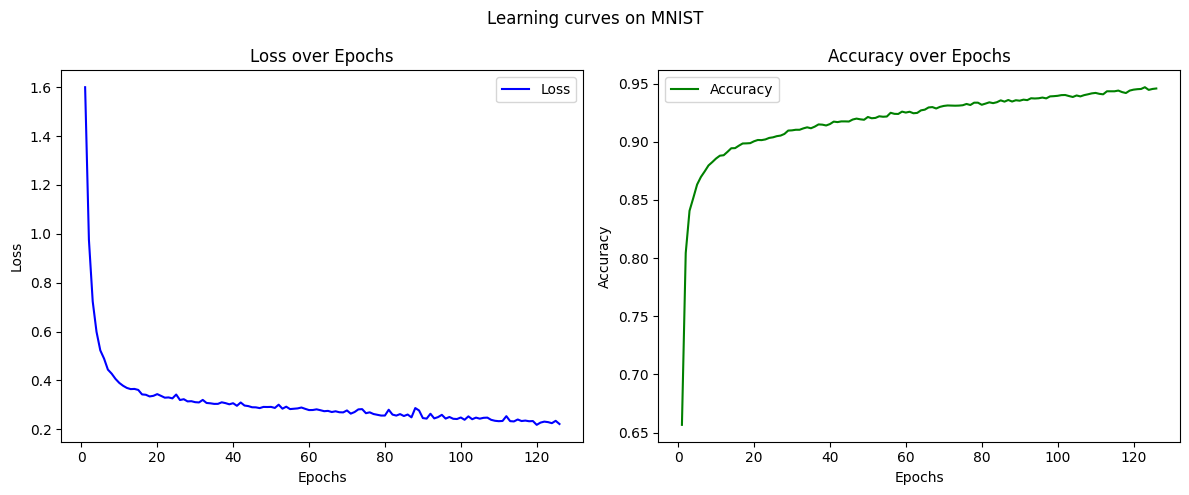

In [76]:
import math
import gc

gc.collect()

losses, accuracies, elapsed = train_n_rounds_hybrid(
    pool_mnist,
    T_final=T_FINAL_MIN * 60,
    clients_per_round=math.ceil(len(pool_mnist.clients) * C),
    problem="mnist"
)

# save data
save_data(pool_mnist, losses, accuracies, elapsed, "hybrid_400_mnist")

plot_loss_accuracy(losses, accuracies, title="Learning curves on MNIST")


Running round: 1 - Time elapsed: 0.0 seconds
Server requesting clients resources...
Model Size: 5368488 bytes
Server selecting clients to train locally...
scheduled final time is 169.06002909656178
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.321012492382427
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 35.30000000000023/35.37136215444637 [00:36<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 126.40658211708069 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.1072, test loss: 2.3418, round_time: 167.27157044410706 sec

Running round: 2 - Time elapsed: 167.2715723514557 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 156.20965362434606
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.317837724302947
Time upload: 0
Time upload: 0.18125796614811115
Time upload: 0.3443901356814112
Time upload: 0.48939650859990014
Time upload: 0.6344028815183886
Time upload: 0.743157661207255
Time upload: 0.8337866442813103
Time upload: 0.8700382375109325
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 29.100000000000144/29.123464871612573 [00:29<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 123.60945725440979 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.1670, test loss: 3.2312, round_time: 157.21178436279297 sec

Running round: 3 - Time elapsed: 324.4856882095337 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 176.8221112590963
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.4286021335531123
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.30000000000016/30.305660200603135 [00:30<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 148.04946446418762 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.1284, test loss: 3.1367, round_time: 182.4705696105957 sec

Running round: 4 - Time elapsed: 506.95826840400696 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 170.21768486001582
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Deadline: 2.1839027822473356
Time upload: 0
Time upload: 0.18420698499068974
Time upload: 0.36841396998137943
Time upload: 0.5545282643201979
Time upload: 0.7415962133330809
Time upload: 0.9111971185209592
Time upload: 1.0817516783829015
Time upload: 1.2532598929189087
Time upload: 1.4257217621289804
Time upload: 1.5797629328399831
Time upload: 1.6960090518787836
Time upload: 1.7928808177444506
Time upload: 1.8316295240907174
Time upload: 1.8510038772638508
Time upl

Distributing model...: 100%|█████████▉| 36.50000000000025/36.50567700092577 [00:37<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 133.6719253063202 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.1615, test loss: 3.7316, round_time: 175.79365754127502 sec

Running round: 5 - Time elapsed: 682.7540285587311 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 162.85654196437
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.3551302278639357
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 35.10000000000023/35.10568240099601 [00:35<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 130.87771201133728 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.1579, test loss: 3.4239, round_time: 170.14647102355957 sec

Running round: 6 - Time elapsed: 852.9021008014679 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.85976812707844
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Deadline: 2.4626935343774563
Time upload: 0
Time upload: 0.1502379641161242
Time upload: 0.30047592823224845
Time upload: 0.45341598931040333
Time upload: 0.6063560503885582
Time upload: 0.7674024023528047
Time upload: 0.9338529482411121
Time upload: 1.0906838916418675
Time upload: 1.2475148350426226
Time upload: 1.3715960886581224
Time upload: 1.4779514488999794
Time upload: 1.531129129020908
Time upload: 1.5843068091418364
Time upload: 1.619758595889122
Selected d

Distributing model...: 100%|█████████▉| 30.600000000000165/30.6378290822492 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 148.27841210365295 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.1776, test loss: 3.2050, round_time: 184.28508877754211 sec

Running round: 7 - Time elapsed: 1037.189083814621 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 174.21058397138347
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.1329090549017793
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.000000000000156/30.014889327636826 [00:30<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 158.87012696266174 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2289, test loss: 2.8619, round_time: 193.06705498695374 sec

Running round: 8 - Time elapsed: 1230.2578670978546 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 174.03556437932974
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.263591514658971
Time upload: 0
Time upload: 0.18479650604141137
Time upload: 0.36959301208282275
Time upload: 0.5543895181242341
Time upload: 0.6652674217490809
Time upload: 0.7576656747697866
Time upload: 0.8315842771863512
Time upload: 0.8870232289987746
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 29.400000000000148/29.47615670079465 [00:30<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 164.44514775276184 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2447, test loss: 2.4908, round_time: 198.4496283531189 sec

Running round: 9 - Time elapsed: 1428.709572315216 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 175.55593416409803
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.542962485834789
Time upload: 0
Time upload: 0.17269354606043702
Time upload: 0.34538709212087415
Time upload: 0.483541928969224
Time upload: 0.6044274112115301
Time upload: 0.6907741842417487
Time upload: 0.7598516026659237
Time upload: 0.8116596664840549
Time upload: 0.8461983756961423
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 31.100000000000172/31.112286121811803 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 144.74268770217896 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2157, test loss: 2.8753, round_time: 180.54853200912476 sec

Running round: 10 - Time elapsed: 1609.2598288059235 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 172.46465430868238
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.2600278570913304
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 28.80000000000014/28.876485787898062 [00:29<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 161.4543297290802 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2231, test loss: 2.7834, round_time: 194.27006673812866 sec

Running round: 11 - Time elapsed: 1803.531622171402 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 166.0326534490711
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 3
Deadline: 2.2680970421293334
Time upload: 0
Time upload: 0.17741630560161684
Time upload: 0.3554908296231565
Time upload: 0.5342235720646189
Time upload: 0.7129563145060809
Time upload: 0.8923472753674656
Time upload: 1.073054673068696
Time upload: 1.2568698101745914
Time upload: 1.4406849472804868
Time upload: 1.605862802543811
Time upload: 1.7721737419520314
Time upload: 1.9387221142227382
Time upload: 2.0873455032383337
Time upload: 2.2175690432738446
Selected dat

Distributing model...: 100%|█████████▉| 36.300000000000246/36.3506434757209 [00:37<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 142.8737337589264 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2833, test loss: 2.5416, round_time: 185.26107621192932 sec

Running round: 12 - Time elapsed: 1988.7948207855225 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 162.01488043884896
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.343997006951376
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.50000000000019/32.50648443256633 [00:33<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 139.29658579826355 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2520, test loss: 2.8348, round_time: 175.9257481098175 sec

Running round: 13 - Time elapsed: 2164.7224526405334 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 155.51578206095957
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.2692593078715966
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.40000000000022/34.48913286978721 [00:35<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 125.41418266296387 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2462, test loss: 2.9502, round_time: 163.93188333511353 sec

Running round: 14 - Time elapsed: 2328.6563584804535 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 158.03740414201485
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Deadline: 2.212382680193698
Time upload: 0
Time upload: 0.15625049156825663
Time upload: 0.31250098313651326
Time upload: 0.472708395709514
Time upload: 0.6329158082825144
Time upload: 0.8049939838697473
Time upload: 0.9849860014664686
Time upload: 1.137684841754283
Time upload: 1.2903836820420975
Time upload: 1.447039443334656
Time upload: 1.564531264304075
Time upload: 1.662441115111924
Time upload: 1.7016050554350637
Time upload: 1.7211870255966335
Time upload:

Distributing model...: 100%|█████████▉| 32.40000000000019/32.49385568435258 [00:33<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 125.61175537109375 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2207, test loss: 3.0380, round_time: 163.51136374473572 sec

Running round: 15 - Time elapsed: 2492.1697583198547 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 173.43383904484529
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.381329818638933
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 35.10000000000023/35.15863074386057 [00:35<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 135.3218674659729 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2111, test loss: 3.0688, round_time: 174.5480921268463 sec

Running round: 16 - Time elapsed: 2666.719591140747 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.41169710467807
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.339172498065068
Time upload: 0
Time upload: 0.15870979948829114
Time upload: 0.3015486190277532
Time upload: 0.4285164586183863
Time upload: 0.5554842982090193
Time upload: 0.6507101779019941
Time upload: 0.7300650776461398
Time upload: 0.7618070375437981
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 32.800000000000196/32.859224742499045 [00:33<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 146.9223289489746 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2428, test loss: 2.6322, round_time: 184.4071183204651 sec

Running round: 17 - Time elapsed: 2851.1285223960876 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 167.07314973763812
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.3049075917329866
Time upload: 0
Time upload: 0.15105334783181368
Time upload: 0.30210669566362747
Time upload: 0.4229493739290785
Time upload: 0.5286867174113481
Time upload: 0.619318726110436
Time upload: 0.6797400652431613
Time upload: 0.7401614043758866
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.2000000000002/33.207478456490456 [00:33<00:00,  1.02s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 129.11089849472046 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2758, test loss: 2.8108, round_time: 166.95900869369507 sec

Running round: 18 - Time elapsed: 3018.0893845558167 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.90698816234027
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.209089244056799
Time upload: 0
Time upload: 0.1683398701125949
Time upload: 0.31984575321393033
Time upload: 0.45451764930400623
Time upload: 0.5891895453940822
Time upload: 0.7070274544728986
Time upload: 0.791197389529196
Time upload: 0.8080313765404555
Time upload: 0.824865363551715
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 31.200000000000173/31.29941615094872 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 151.9506766796112 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2865, test loss: 2.7486, round_time: 187.82993841171265 sec

Running round: 19 - Time elapsed: 3205.9217505455017 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 155.56352963170792
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.300879128831731
Time upload: 0
Time upload: 0.17858771033300416
Time upload: 0.3571754206660083
Time upload: 0.5357631309990126
Time upload: 0.6429157571988154
Time upload: 0.7322096123653178
Time upload: 0.8036446964985197
Time upload: 0.8572210095984211
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.000000000000185/32.04287643904619 [00:32<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 131.70424604415894 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3109, test loss: 2.5189, round_time: 168.36724495887756 sec

Running round: 20 - Time elapsed: 3374.2909162044525 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 167.18725884790575
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.2475399333531256
Time upload: 0
Time upload: 0.1531562559740737
Time upload: 0.29099688635074
Time upload: 0.41352189112999876
Time upload: 0.5360468959092577
Time upload: 0.6432562750911095
Time upload: 0.7198344030781465
Time upload: 0.7351500286755539
Time upload: 0.7504656542729613
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.50000000000022/34.51314781975067 [00:35<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 132.75137162208557 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2952, test loss: 2.8429, round_time: 171.8928143978119 sec

Running round: 21 - Time elapsed: 3546.1854832172394 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 158.38942863839574
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Deadline: 2.189386400501245
Time upload: 0
Time upload: 0.1870103200569324
Time upload: 0.3740206401138647
Time upload: 0.5633490263670919
Time upload: 0.7538364457184669
Time upload: 0.9454828981679891
Time upload: 1.1394474168138056
Time upload: 1.2738317401481003
Time upload: 1.3918330976729962
Time upload: 1.5109934882960394
Time upload: 1.610293813815242
Time upload: 1.7095941393344447
Time upload: 1.8088944648536474
Time upload: 1.8486145950613284
Time upload

Distributing model...: 100%|█████████▉| 33.1000000000002/33.17498175828345 [00:33<00:00,  1.02s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 128.19375729560852 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3192, test loss: 2.2878, round_time: 166.92125344276428 sec

Running round: 22 - Time elapsed: 3713.108423233032 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 158.5654560287966
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Deadline: 2.3895630871740363
Time upload: 0
Time upload: 0.17707063952175942
Time upload: 0.3541412790435187
Time upload: 0.5328297426139064
Time upload: 0.7123271182086082
Time upload: 0.8934423178519384
Time upload: 1.0383344775666026
Time upload: 1.1655195733290908
Time upload: 1.2749976051394032
Time upload: 1.3852845489740298
Time upload: 1.4963804048329705
Time upload: 1.6074762606919113
Time upload: 1.718572116550852
Time upload: 1.7741200444803225
Selected d

Distributing model...: 100%|█████████▉| 31.70000000000018/31.71130640246542 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 128.01466584205627 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3236, test loss: 2.5100, round_time: 165.0440535545349 sec

Running round: 23 - Time elapsed: 3878.15442943573 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 163.93826949605653
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.2629618604837574
Time upload: 0
Time upload: 0.17627750341748472
Time upload: 0.3525550068349693
Time upload: 0.5288325102524539
Time upload: 0.6345990123029447
Time upload: 0.722737764011687
Time upload: 0.7932487653786808
Time upload: 0.8285042660621778
Time upload: 0.8637597667456747
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.9000000000002/32.90648618396288 [00:33<00:00,  1.02s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 131.04573678970337 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3062, test loss: 2.9617, round_time: 168.58866238594055 sec

Running round: 24 - Time elapsed: 4046.7451627254486 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 169.69129858719205
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.2706344048223017
Time upload: 0
Time upload: 0.17524483777864874
Time upload: 0.3504896755572974
Time upload: 0.525734513335946
Time upload: 0.6308814160031352
Time upload: 0.7185038348924595
Time upload: 0.788601770003919
Time upload: 0.8236507375596487
Time upload: 0.8586997051153784
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 35.90000000000024/35.93409369836953 [00:36<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 133.76705980300903 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3070, test loss: 2.3917, round_time: 174.4239604473114 sec

Running round: 25 - Time elapsed: 4221.170917510986 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 176.91265255078258
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.270323376941382
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.90000000000017/30.98596960921659 [00:31<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 146.02374601364136 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2860, test loss: 2.6143, round_time: 181.081693649292 sec

Running round: 26 - Time elapsed: 4402.254279375076 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.36256494764578
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.3994773095987547
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 33.400000000000205/33.424965809858804 [00:34<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 145.23406052589417 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3414, test loss: 2.2629, round_time: 182.69654846191406 sec

Running round: 27 - Time elapsed: 4584.95242023468 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 177.08883434092417
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.2124831699712275
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.500000000000163/30.513131402646085 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 145.9876687526703 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2982, test loss: 3.0317, round_time: 180.53469324111938 sec

Running round: 28 - Time elapsed: 4765.489023208618 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 172.4690653740914
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Deadline: 2.401492050299362
Time upload: 0
Time upload: 0.16217441745606298
Time upload: 0.32434883491212596
Time upload: 0.48652325236818894
Time upload: 0.6511763593931295
Time upload: 0.8164491388102897
Time upload: 0.9655044764818435
Time upload: 1.1151794865456162
Time upload: 1.2486370548637824
Time upload: 1.3664968538285618
Time upload: 1.45068242451769
Time upload: 1.534867995206818
Time upload: 1.585379337620295
Time upload: 1.6190535658959462
Selected data

Distributing model...: 100%|█████████▉| 29.100000000000144/29.179742655793053 [00:29<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 143.2917022705078 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2948, test loss: 2.3351, round_time: 177.74422097206116 sec

Running round: 29 - Time elapsed: 4943.235080718994 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 176.55167698871782
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.416376509473421
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 29.700000000000152/29.758409246847595 [00:30<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 150.038982629776 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3760, test loss: 1.9105, round_time: 183.7581217288971 sec

Running round: 30 - Time elapsed: 5126.995207071304 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 177.64391255847255
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.3417829062615936
Time upload: 0
Time upload: 0.16198941069269354
Time upload: 0.3077798803161177
Time upload: 0.43737140887027237
Time upload: 0.566962937424427
Time upload: 0.6803555249093124
Time upload: 0.7613502302556591
Time upload: 0.7775491713249284
Time upload: 0.7937481123941977
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.400000000000162/30.426974721133696 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 161.71859431266785 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3401, test loss: 2.2934, round_time: 196.7505784034729 sec

Running round: 31 - Time elapsed: 5323.747780561447 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 158.58281441002782
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.2223338407220155
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 35.90000000000024/35.984957967280266 [00:36<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 122.61435508728027 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2526, test loss: 3.3243, round_time: 162.65569949150085 sec

Running round: 32 - Time elapsed: 5486.4054498672485 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 158.57442113802034
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.189157413712073
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.1000000000002/33.16581969149329 [00:33<00:00,  1.02s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 133.08541870117188 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3664, test loss: 2.1768, round_time: 170.3857238292694 sec

Running round: 33 - Time elapsed: 5656.793737411499 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 176.94436805736458
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.36283686111074
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 31.00000000000017/31.03203104034356 [00:31<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 160.68224239349365 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2946, test loss: 2.7019, round_time: 195.84085702896118 sec

Running round: 34 - Time elapsed: 5852.636573076248 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 177.8962062075708
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.2795136168704953
Time upload: 0
Time upload: 0.16060149258198883
Time upload: 0.3212029851639776
Time upload: 0.48180447774596635
Time upload: 0.5781653732951596
Time upload: 0.658466119586154
Time upload: 0.7227067166189495
Time upload: 0.7708871643935461
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.600000000000165/30.611833771391527 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 148.4233524799347 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3887, test loss: 1.9928, round_time: 183.53445982933044 sec

Running round: 35 - Time elapsed: 6036.173003435135 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 163.34458420377365
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.3928498430402527
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.00000000000021/34.08428326723509 [00:34<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 129.27212285995483 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3268, test loss: 2.5855, round_time: 167.3295259475708 sec

Running round: 36 - Time elapsed: 6203.504504442215 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.56371702655343
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.2909206869169014
Time upload: 0
Time upload: 0.17617957729711423
Time upload: 0.35235915459422845
Time upload: 0.4933028164319198
Time upload: 0.6166285205398998
Time upload: 0.7047183091884569
Time upload: 0.7751901401073026
Time upload: 0.8280440132964368
Time upload: 0.8632799287558597
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 32.50000000000019/32.53926194697454 [00:33<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 147.11968064308167 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3829, test loss: 2.4410, round_time: 184.21696996688843 sec

Running round: 37 - Time elapsed: 6387.7238800525665 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 163.62936173902983
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.3030889719001353
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.60000000000019/32.66002515703918 [00:33<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 128.221337556839 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4248, test loss: 2.0462, round_time: 164.8936276435852 sec

Running round: 38 - Time elapsed: 6552.619144439697 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 161.48346013445712
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Deadline: 2.1592454227130427
Time upload: 0
Time upload: 0.18938053965749221
Time upload: 0.3802319956638474
Time upload: 0.5725543680190657
Time upload: 0.764876740374284
Time upload: 0.9586700290783654
Time upload: 1.1554051504801728
Time upload: 1.3580239372774319
Time upload: 1.5402337537600788
Time upload: 1.6816256296135013
Time upload: 1.7836704811865622
Time upload: 1.865306362445011
Time upload: 1.9265332733888476
Time upload: 1.9469422437034598
Selected data

Distributing model...: 100%|█████████▉| 33.80000000000021/33.831210014480945 [00:34<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 130.08938217163086 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3680, test loss: 2.5539, round_time: 169.378515958786 sec

Running round: 39 - Time elapsed: 6721.999527454376 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 166.20240980245018
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.241210672612296
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 35.600000000000236/35.68630847576003 [00:36<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 131.060941696167 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3339, test loss: 2.8425, round_time: 170.9161820411682 sec

Running round: 40 - Time elapsed: 6892.9178330898285 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.16864896598156
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.4526876930946613
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 31.100000000000172/31.13618341588022 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 147.66127753257751 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2957, test loss: 2.7435, round_time: 182.8020098209381 sec

Running round: 41 - Time elapsed: 7075.721567153931 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 160.43648255865972
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.2320327639711794
Time upload: 0
Time upload: 0.20939259605463778
Time upload: 0.3978459325038118
Time upload: 0.5653600093475222
Time upload: 0.7328740861912328
Time upload: 0.8585096438240158
Time upload: 0.963205941851335
Time upload: 1.0050844610622627
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.2000000000002/33.24998311509988 [00:33<00:00,  1.02s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 130.27434635162354 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3330, test loss: 2.6758, round_time: 168.04542565345764 sec

Running round: 42 - Time elapsed: 7243.768742322922 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 175.24456979117772
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.1568910471294753
Time upload: 0
Time upload: 0.1948838885867914
Time upload: 0.3897677771735829
Time upload: 0.545674888043016
Time upload: 0.6820936100537697
Time upload: 0.7795355543471651
Time upload: 0.8574891097818815
Time upload: 0.9159542763579188
Time upload: 0.954931054075277
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.400000000000162/30.45444837390337 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 145.80200576782227 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3486, test loss: 2.6709, round_time: 180.86079716682434 sec

Running round: 43 - Time elapsed: 7424.631381750107 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 155.0015130625091
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Deadline: 2.3650269477576495
Time upload: 0
Time upload: 0.1572816491808333
Time upload: 0.3145632983616665
Time upload: 0.47870870601307847
Time upload: 0.6462859928997801
Time upload: 0.8172951590217711
Time upload: 0.976008039460968
Time upload: 1.1155608757467927
Time upload: 1.246249305585113
Time upload: 1.3612095705053497
Time upload: 1.4761698354255866
Time upload: 1.5719700561924506
Time upload: 1.6486102328059418
Time upload: 1.7060903652660602
Selected da

Distributing model...: 100%|█████████▉| 31.400000000000176/31.490439945574042 [00:32<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 123.55215358734131 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3336, test loss: 2.6641, round_time: 160.29732179641724 sec

Running round: 44 - Time elapsed: 7584.930428266525 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 176.70347836725506
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.2465596855522336
Time upload: 0
Time upload: 0.19050589169008858
Time upload: 0.3619611942111684
Time upload: 0.5143659075632393
Time upload: 0.6667706209153098
Time upload: 0.7810741559293627
Time upload: 0.8763271017744068
Time upload: 0.9144282801124244
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.400000000000162/30.485173501747365 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 146.23117756843567 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3662, test loss: 2.3228, round_time: 181.20854115486145 sec

Running round: 45 - Time elapsed: 7766.140818834305 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 158.7334961942498
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.3041890561584264
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.40000000000022/34.499405776965204 [00:35<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 124.27966213226318 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2957, test loss: 3.1846, round_time: 162.77281618118286 sec

Running round: 46 - Time elapsed: 7928.915494441986 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 175.12749142488173
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.158792481933729
Time upload: 0
Time upload: 0.18020147233612438
Time upload: 0.36040294467224887
Time upload: 0.5045641225411485
Time upload: 0.6307051531764356
Time upload: 0.7208058893444979
Time upload: 0.7928864782789476
Time upload: 0.846946919979785
Time upload: 0.8829872144470099
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 29.800000000000153/29.866496640760495 [00:30<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 145.35590958595276 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3861, test loss: 2.2698, round_time: 179.68091130256653 sec

Running round: 47 - Time elapsed: 8108.598338842392 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 161.98927146358326
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 3
Deadline: 2.4311268369886427
Time upload: 0
Time upload: 0.1705080464363606
Time upload: 0.3410160928727212
Time upload: 0.5115241393090818
Time upload: 0.6826820879746179
Time upload: 0.8540025121974479
Time upload: 1.0296165434745406
Time upload: 1.2053930503089267
Time upload: 1.381332032700607
Time upload: 1.5617270977038438
Time upload: 1.7503844257010182
Time upload: 1.9390417536981925
Time upload: 2.144223607683241
Time upload: 2.3321921814673585
Selected da

Distributing model...: 100%|█████████▉| 32.700000000000195/32.72616590146833 [00:33<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 125.46110892295837 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3819, test loss: 2.2880, round_time: 164.21298718452454 sec

Running round: 48 - Time elapsed: 8272.813072919846 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 174.17670970154487
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.3420787681847988
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.000000000000156/30.051834676161572 [00:30<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 143.81441736221313 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3613, test loss: 2.5776, round_time: 177.9875292778015 sec

Running round: 49 - Time elapsed: 8450.802622556686 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 162.84012772012056
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.2329172342444283
Time upload: 0
Time upload: 0.17698512120246648
Time upload: 0.35397024240493297
Time upload: 0.5132568514871528
Time upload: 0.6725434605693726
Time upload: 0.7787345332908525
Time upload: 0.8495285817718391
Time upload: 0.8672270938920857
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.0000000000002/33.091574855673855 [00:33<00:00,  1.02s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 130.19135808944702 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3795, test loss: 2.7190, round_time: 167.72796392440796 sec

Running round: 50 - Time elapsed: 8618.532519102097 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 157.31571527870204
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Deadline: 2.4137528823144723
Time upload: 0
Time upload: 0.15635975291331874
Time upload: 0.3187651179676685
Time upload: 0.4811704830220182
Time upload: 0.6496214602173989
Time upload: 0.8024364621214476
Time upload: 0.9794339125896201
Time upload: 1.156431363057793
Time upload: 1.3238384503756646
Time upload: 1.4972911498345671
Time upload: 1.6707438492934696
Time upload: 1.8008333738876465
Time upload: 1.8441965487523722
Selected data length (|D_UL|): 307200
Sel

Distributing model...: 100%|█████████▉| 32.50000000000019/32.5418953952372 [00:33<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 128.47264742851257 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.2913, test loss: 2.9912, round_time: 166.25082635879517 sec

Running round: 51 - Time elapsed: 8784.78525185585 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 155.8873225294981
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.2732440728747814
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.800000000000196/32.884548758957116 [00:33<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 123.00916385650635 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3891, test loss: 2.3987, round_time: 159.88089227676392 sec

Running round: 52 - Time elapsed: 8944.6680727005 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.24587074412244
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.373052481033741
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 31.100000000000172/31.1650085656832 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 147.1811294555664 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3708, test loss: 2.7352, round_time: 182.4047074317932 sec

Running round: 53 - Time elapsed: 9127.074552059174 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 158.10466318163222
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.4046233972754436
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 31.900000000000183/31.959221564523865 [00:32<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 127.11269044876099 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3904, test loss: 2.4337, round_time: 163.0030391216278 sec

Running round: 54 - Time elapsed: 9290.079455375671 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.87909175116897
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 3
Deadline: 2.22071563613211
Time upload: 0
Time upload: 0.17178117829223452
Time upload: 0.3435623565844691
Time upload: 0.5155556919814256
Time upload: 0.6876551059307426
Time upload: 0.8599666769847817
Time upload: 1.0323843265911818
Time upload: 1.206637337774104
Time upload: 1.3827257105335482
Time upload: 1.5606494448695145
Time upload: 1.7265829104487407
Time upload: 1.8925163760279669
Time upload: 2.0394363622014473
Time upload: 2.1690721519933436
Selected dat

Distributing model...: 100%|█████████▉| 31.400000000000176/31.459429793953184 [00:32<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 148.05219507217407 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3693, test loss: 2.5572, round_time: 185.47115969657898 sec

Running round: 55 - Time elapsed: 9475.552526473999 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 161.0045738112084
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.2989850928675537
Time upload: 0
Time upload: 0.1605958933331
Time upload: 0.30513219733288993
Time upload: 0.4496685013326797
Time upload: 0.5781452159991596
Time upload: 0.6905623413323294
Time upload: 0.7387411093322593
Time upload: 0.7869198773321893
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.3000000000002/33.33726449626219 [00:33<00:00,  1.02s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 127.73004937171936 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3341, test loss: 2.8306, round_time: 165.66612100601196 sec

Running round: 56 - Time elapsed: 9641.220445632935 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 177.6641089062355
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.2608131815093406
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 33.60000000000021/33.64226437226928 [00:34<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 143.4318175315857 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3746, test loss: 2.2071, round_time: 181.18981838226318 sec

Running round: 57 - Time elapsed: 9822.412326574326 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 160.3432116437338
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.286980889141997
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.400000000000205/33.402511949485756 [00:34<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 129.6997127532959 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3370, test loss: 2.6875, round_time: 167.0810296535492 sec

Running round: 58 - Time elapsed: 9989.495279073715 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 154.74441197771014
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 3
Deadline: 2.243898512460285
Time upload: 0
Time upload: 0.16596527043230366
Time upload: 0.33193054086460744
Time upload: 0.49884683322274
Time upload: 0.6662386365437867
Time upload: 0.8341059508277477
Time upload: 1.0029242870375377
Time upload: 1.1717426232473274
Time upload: 1.3423016994853874
Time upload: 1.513964700965417
Time upload: 1.6862561167245018
Time upload: 1.8588617396231144
Time upload: 2.0320957768007823
Time upload: 2.187943568832778
Selected data 

Distributing model...: 100%|█████████▉| 34.100000000000215/34.155282462977006 [00:34<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 126.20108127593994 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3741, test loss: 2.8483, round_time: 166.2848515510559 sec

Running round: 59 - Time elapsed: 10155.781874656677 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.18986544091595
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.3098968253718946
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.600000000000165/30.69882348242751 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 147.05394291877747 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3829, test loss: 2.5259, round_time: 181.66563534736633 sec

Running round: 60 - Time elapsed: 10337.449673891068 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 156.74507407106375
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.349037492078286
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.30000000000019/32.37247718293837 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 137.0632929801941 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3905, test loss: 2.4527, round_time: 173.34450697898865 sec

Running round: 61 - Time elapsed: 10510.796146392822 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.48605205102854
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.240695124612143
Time upload: 0
Time upload: 0.1823231946757514
Time upload: 0.3646463893515028
Time upload: 0.546969584027254
Time upload: 0.6563635008327046
Time upload: 0.74752509817058
Time upload: 0.8204543760408803
Time upload: 0.8751513344436056
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 32.000000000000185/32.076742787367166 [00:32<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 147.63676857948303 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3673, test loss: 2.6680, round_time: 184.21593856811523 sec

Running round: 62 - Time elapsed: 10695.013825893402 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 176.26836469531838
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 3
Deadline: 2.34607987731922
Time upload: 0
Time upload: 0.17020470838464144
Time upload: 0.3405223423754877
Time upload: 0.5109529019725387
Time upload: 0.6813834615695897
Time upload: 0.8520398723790503
Time upload: 1.0237846344523573
Time upload: 1.197819024659562
Time upload: 1.3718534148667665
Time upload: 1.5461136562863804
Time upload: 1.7213493233636359
Time upload: 1.8794515939962224
Time upload: 2.0023116460818295
Time upload: 2.1090137273804093
Time uploa

Distributing model...: 100%|█████████▉| 30.500000000000163/30.540111760737926 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 145.74932193756104 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4029, test loss: 2.1407, round_time: 182.43524146080017 sec

Running round: 63 - Time elapsed: 10877.450740337372 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 161.25601913937055
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.135596154955005
Time upload: 0
Time upload: 0.18311997794770077
Time upload: 0.36623995589540137
Time upload: 0.5127359382535618
Time upload: 0.6409199228169525
Time upload: 0.7324799117908031
Time upload: 0.8057279029698835
Time upload: 0.8606638963541938
Time upload: 0.897287891943734
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.30000000000019/32.31478074357136 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 133.19068360328674 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3780, test loss: 2.7025, round_time: 170.0334026813507 sec

Running round: 64 - Time elapsed: 11047.486071586609 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 159.54333201101312
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.3419389627385594
Time upload: 0
Time upload: 0.18770578879378397
Time upload: 0.35664099870818944
Time upload: 0.5068056297432165
Time upload: 0.6569702607782436
Time upload: 0.7883643129338923
Time upload: 0.8822172073307842
Time upload: 0.9009877862101626
Time upload: 0.919758365089541
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.20000000000019/32.285540195746215 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 125.01937437057495 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4126, test loss: 2.4787, round_time: 161.76788187026978 sec

Running round: 65 - Time elapsed: 11209.256065607071 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.94522514546085
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.50005845072401
Time upload: 0
Time upload: 0.17836723991147996
Time upload: 0.3388977558318119
Time upload: 0.4815915477609959
Time upload: 0.6242853396901799
Time upload: 0.7313056836370678
Time upload: 0.8204893035928078
Time upload: 0.8561627515751038
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 31.200000000000173/31.250914792531404 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 150.01081657409668 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4101, test loss: 2.2729, round_time: 185.77243542671204 sec

Running round: 66 - Time elapsed: 11395.030225753784 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.98552304371253
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.36895007120832
Time upload: 0
Time upload: 0.17836624925554811
Time upload: 0.35673249851109634
Time upload: 0.5350987477666446
Time upload: 0.6421184973199735
Time upload: 0.7313016219477476
Time upload: 0.8026481216499669
Time upload: 0.8383213715010766
Time upload: 0.8739946213521862
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 32.50000000000019/32.59237550025027 [00:33<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 148.1489520072937 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4176, test loss: 2.4638, round_time: 185.1335289478302 sec

Running round: 67 - Time elapsed: 11580.165790081024 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.80755646406666
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.2846907720520186
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 31.300000000000175/31.385556550747793 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 148.50218033790588 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3694, test loss: 2.7884, round_time: 183.78802299499512 sec

Running round: 68 - Time elapsed: 11763.955507040024 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 174.5643567790674
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Deadline: 2.2637413790413836
Time upload: 0
Time upload: 0.16185223038513444
Time upload: 0.3237044607702689
Time upload: 0.4855566911554033
Time upload: 0.6664276533369252
Time upload: 0.852053298467544
Time upload: 1.0424336265472596
Time upload: 1.2423233205251691
Time upload: 1.4212731085154684
Time upload: 1.5630977674796438
Time upload: 1.6677972974176953
Time upload: 1.7515569213681366
Time upload: 1.8143766393309675
Time upload: 1.8353165453185778
Selected 

Distributing model...: 100%|█████████▉| 36.00000000000024/36.00713393655512 [00:36<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 153.2716040611267 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4104, test loss: 2.6885, round_time: 194.66508531570435 sec

Running round: 69 - Time elapsed: 11958.622456789017 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 176.5357066208784
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.362834360622593
Time upload: 0
Time upload: 0.1821139820328385
Time upload: 0.3642279640656768
Time upload: 0.5099191496919474
Time upload: 0.6373989371149346
Time upload: 0.728455928131354
Time upload: 0.8013015209444895
Time upload: 0.8559357155543411
Time upload: 0.8923585119609089
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 37.20000000000026/37.254179393213114 [00:37<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 138.50887751579285 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4468, test loss: 2.2944, round_time: 180.33109498023987 sec

Running round: 70 - Time elapsed: 12138.955237150192 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 175.06289031853166
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.3030788621181553
Time upload: 0
Time upload: 0.1742336885691147
Time upload: 0.331044008281318
Time upload: 0.47043095913660987
Time upload: 0.6098179099919013
Time upload: 0.7143581231333699
Time upload: 0.801474967417927
Time upload: 0.8363217051317499
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 29.700000000000152/29.734183427723934 [00:30<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 164.29432463645935 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4287, test loss: 2.6139, round_time: 198.50469374656677 sec

Running round: 71 - Time elapsed: 12337.461629629135 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 164.32249606846858
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.2856114783469925
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.3000000000002/33.36592885131641 [00:33<00:00,  1.02s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 127.43800830841064 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4080, test loss: 2.5083, round_time: 164.8091173171997 sec

Running round: 72 - Time elapsed: 12502.272851467133 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.72339269246672
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.1261531296535012
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 33.400000000000205/33.47016889118758 [00:34<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 146.26434803009033 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3558, test loss: 2.9235, round_time: 183.72979307174683 sec

Running round: 73 - Time elapsed: 12686.004524946213 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 157.1898323738135
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.2474229792766787
Time upload: 0
Time upload: 0.18016878992159704
Time upload: 0.3603375798431941
Time upload: 0.5044726117804718
Time upload: 0.6305907647255901
Time upload: 0.7386920386785486
Time upload: 0.8107595546471876
Time upload: 0.8828270706158267
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.70000000000022/34.74355525574258 [00:35<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 122.53007125854492 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4181, test loss: 2.6290, round_time: 161.80765581130981 sec

Running round: 74 - Time elapsed: 12847.813945770264 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 175.8589222272651
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.2804640450612457
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 37.000000000000256/37.03797611828024 [00:37<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 138.89866828918457 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3923, test loss: 3.5521, round_time: 180.04685926437378 sec

Running round: 75 - Time elapsed: 13027.862935066223 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.7898360601129
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.286707181907886
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 32.50000000000019/32.557732377338255 [00:33<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 147.32555603981018 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4455, test loss: 2.2869, round_time: 183.96534538269043 sec

Running round: 76 - Time elapsed: 13211.83013677597 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.90719281266334
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.213297487962322
Time upload: 0
Time upload: 0.1787018730581198
Time upload: 0.3574037461162395
Time upload: 0.5003652445627352
Time upload: 0.6254565557034194
Time upload: 0.7148074922324795
Time upload: 0.7862882414557276
Time upload: 0.8398988033731637
Time upload: 0.8756391779847877
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.90000000000017/30.961283027863864 [00:31<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 149.93361139297485 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3755, test loss: 2.4367, round_time: 185.42527604103088 sec

Running round: 77 - Time elapsed: 13397.25726389885 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 162.51688098981623
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 3
Deadline: 2.2270872496270817
Time upload: 0
Time upload: 0.1700374253681178
Time upload: 0.34050812292771343
Time upload: 0.5114120926787868
Time upload: 0.6823160624298603
Time upload: 0.8540865765638892
Time upload: 1.028479838023881
Time upload: 1.2085518663272763
Time upload: 1.3886238946306715
Time upload: 1.569562467317022
Time upload: 1.7526905151378582
Time upload: 1.918381548230405
Time upload: 2.0470090767318876
Time upload: 2.160389065639566
Selected dat

Distributing model...: 100%|█████████▉| 34.60000000000022/34.61692950741303 [00:35<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 127.95426154136658 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4528, test loss: 2.1010, round_time: 168.5031590461731 sec

Running round: 78 - Time elapsed: 13565.762235164642 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 174.31129034492363
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.292328823866016
Time upload: 0
Time upload: 0.19051872605111322
Time upload: 0.38103745210222645
Time upload: 0.5334524329431171
Time upload: 0.6668155411788963
Time upload: 0.7620749042044529
Time upload: 0.8382823946248982
Time upload: 0.8954380124402321
Time upload: 0.9335417576504548
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 31.900000000000183/31.933956950113505 [00:32<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 142.22426557540894 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3996, test loss: 2.6867, round_time: 178.76499795913696 sec

Running round: 79 - Time elapsed: 13744.52919626236 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.40435096138947
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.374246803241623
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.30000000000016/30.359516453338227 [00:30<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 153.5240249633789 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4200, test loss: 2.6926, round_time: 187.86759114265442 sec

Running round: 80 - Time elapsed: 13932.398484230042 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 157.43661730761096
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.19611681529808
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 31.200000000000173/31.29723020719521 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 126.21207404136658 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3986, test loss: 2.4433, round_time: 161.36374855041504 sec

Running round: 81 - Time elapsed: 14093.764095783234 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.531259156909
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.2316691342483908
Time upload: 0
Time upload: 0.1663050779918885
Time upload: 0.33261015598377697
Time upload: 0.48228472617647655
Time upload: 0.6319592963691761
Time upload: 0.7317423431643092
Time upload: 0.7982643743610646
Time upload: 0.8148948821602534
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 32.60000000000019/32.69264992139597 [00:33<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 151.02280640602112 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3690, test loss: 2.5823, round_time: 188.28606796264648 sec

Running round: 82 - Time elapsed: 14282.052542209625 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 172.22199149243997
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.3778020426184647
Time upload: 0
Time upload: 0.18100476554285092
Time upload: 0.34390905453141674
Time upload: 0.5068133435199825
Time upload: 0.6516171559542628
Time upload: 0.7783204918342581
Time upload: 0.8326219214971132
Time upload: 0.8869233511599683
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 29.300000000000146/29.3610803021893 [00:29<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 142.9318392276764 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3538, test loss: 4.3625, round_time: 176.76737308502197 sec

Running round: 83 - Time elapsed: 14458.821861028671 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 163.75828926379074
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Deadline: 2.185082621240825
Time upload: 0
Time upload: 0.1675704920147392
Time upload: 0.3351409840294784
Time upload: 0.5027114760442176
Time upload: 0.6729485558317841
Time upload: 0.8264285864178768
Time upload: 0.9805752639471762
Time upload: 1.1353885884196826
Time upload: 1.273444863690715
Time upload: 1.3954107367034803
Time upload: 1.4999529135715648
Time upload: 1.5696476981502878
Time upload: 1.6393424827290108
Time upload: 1.6741898750183724
Selected da

Distributing model...: 100%|█████████▉| 33.70000000000021/33.75719698848722 [00:34<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 127.65320658683777 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4277, test loss: 2.6532, round_time: 166.7343714237213 sec

Running round: 84 - Time elapsed: 14625.558126211166 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 176.76596679293206
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.2963213746051205
Time upload: 0
Time upload: 0.18827319970764356
Time upload: 0.35771907944452286
Time upload: 0.5083376392106378
Time upload: 0.6589561989767527
Time upload: 0.7719201188013389
Time upload: 0.8660567186551608
Time upload: 0.9037113585966895
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 31.60000000000018/31.633225331238073 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 145.17719674110413 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3844, test loss: 2.7986, round_time: 181.27529191970825 sec

Running round: 85 - Time elapsed: 14806.835178136826 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 177.7457613842472
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Deadline: 2.2520691544056732
Time upload: 0
Time upload: 0.1745299695681762
Time upload: 0.35053728560138114
Time upload: 0.5280219480996147
Time upload: 0.7055066105978478
Time upload: 0.8655382761392634
Time upload: 1.0285246346107366
Time upload: 1.1974203789423254
Time upload: 1.3473857798520679
Time upload: 1.4784208373399639
Time upload: 1.5920028978710423
Time upload: 1.667724271558428
Time upload: 1.7434456452458136
Time upload: 1.7813063320895064
Selected 

Distributing model...: 100%|█████████▉| 31.500000000000178/31.509597772147938 [00:32<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 151.15011930465698 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4207, test loss: 2.5924, round_time: 187.93213868141174 sec

Running round: 86 - Time elapsed: 14994.768828868866 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 160.51728521889137
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.274441545893699
Time upload: 0
Time upload: 0.15257494493467766
Time upload: 0.28989239537588757
Time upload: 0.4272098458170973
Time upload: 0.5492698017648395
Time upload: 0.6560722632191142
Time upload: 0.7018447466995176
Time upload: 0.747617230179921
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 36.300000000000246/36.37061969761154 [00:37<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 124.21846032142639 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3882, test loss: 3.0604, round_time: 165.0634367465973 sec

Running round: 87 - Time elapsed: 15159.834035396576 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 160.47451770942786
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.233727747181446
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.70000000000021/33.74637306672679 [00:34<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 126.38336610794067 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4002, test loss: 3.0853, round_time: 164.20004272460938 sec

Running round: 88 - Time elapsed: 15324.035942554474 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 162.9083490866104
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 3
Deadline: 2.220923765197384
Time upload: 0
Time upload: 0.15116771223231862
Time upload: 0.3023354244646371
Time upload: 0.4544048075299312
Time upload: 0.6069250260117132
Time upload: 0.76216241364915
Time upload: 0.9178506367030748
Time upload: 1.0758051934961665
Time upload: 1.2204584773887057
Time upload: 1.3655625966977327
Time upload: 1.4937344464608486
Time upload: 1.608154187906924
Time upload: 1.7225739293529996
Time upload: 1.8406246674444335
Time upload:

Distributing model...: 100%|█████████▉| 34.200000000000216/34.20520228629048 [00:34<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 130.97641825675964 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3798, test loss: 3.0988, round_time: 171.61507105827332 sec

Running round: 89 - Time elapsed: 15495.653164625168 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 153.86479007806514
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Deadline: 2.3200605653338107
Time upload: 0
Time upload: 0.16783901688700892
Time upload: 0.33567803377401795
Time upload: 0.5129860879753569
Time upload: 0.6950286608338608
Time upload: 0.8865402710066945
Time upload: 1.0397495591449615
Time upload: 1.197693365940393
Time upload: 1.3388532710471237
Time upload: 1.4632292744651536
Time upload: 1.5923397965403485
Time upload: 1.6999318982696776
Time upload: 1.7860055796531409
Time upload: 1.8505608406907383
Time up

Distributing model...: 100%|█████████▉| 30.90000000000017/30.999297047060278 [00:31<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 122.82322549819946 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4248, test loss: 2.5206, round_time: 159.1406455039978 sec

Running round: 90 - Time elapsed: 15654.795811414719 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 170.58254242700576
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.4099172912657227
Time upload: 0
Time upload: 0.15919837527477884
Time upload: 0.3183967505495577
Time upload: 0.4457554507693808
Time upload: 0.5571943134617258
Time upload: 0.6367935010991149
Time upload: 0.7004728512090262
Time upload: 0.7482323637914597
Time upload: 0.7800720388464154
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.800000000000225/34.88125509810757 [00:35<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 155.58672428131104 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3887, test loss: 3.3090, round_time: 195.02706146240234 sec

Running round: 91 - Time elapsed: 15849.824637651443 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 165.8095050620399
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Deadline: 2.2873670212448025
Time upload: 0
Time upload: 0.1629177035286691
Time upload: 0.3294019236305502
Time upload: 0.4958861437324312
Time upload: 0.6460785934814453
Time upload: 0.7998375598036713
Time upload: 0.9678625924187456
Time upload: 1.1358876250338203
Time upload: 1.3110456907953196
Time upload: 1.469911986203952
Time upload: 1.5890617077604263
Time upload: 1.7082114293169006
Time upload: 1.7677862900951378
Selected data length (|D_UL|): 307200
Sele

Distributing model...: 100%|█████████▉| 35.30000000000023/35.30195162846637 [00:36<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 139.96618247032166 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3805, test loss: 3.2735, round_time: 180.6611843109131 sec

Running round: 92 - Time elapsed: 16030.487762928009 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.39827510129075
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.1833928699975305
Time upload: 0
Time upload: 0.19250471556328264
Time upload: 0.38500943112656516
Time upload: 0.5775141466898479
Time upload: 0.6930169760278178
Time upload: 0.7892693338094593
Time upload: 0.8662712200347725
Time upload: 0.9240226347037575
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.600000000000165/30.612803082523165 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 151.33208632469177 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4106, test loss: 2.6416, round_time: 186.40267395973206 sec

Running round: 93 - Time elapsed: 16216.892930746078 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 159.72044110658447
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.2587440321192482
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.800000000000196/32.87748077824224 [00:33<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 126.92306566238403 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3177, test loss: 3.7944, round_time: 163.76503801345825 sec

Running round: 94 - Time elapsed: 16380.659957170486 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 162.92309236308762
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.2783478603335663
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 31.70000000000018/31.791009113504284 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 131.21928310394287 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3934, test loss: 2.9928, round_time: 166.86354851722717 sec

Running round: 95 - Time elapsed: 16547.525403499603 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 157.25511349948133
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.225065976251014
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.100000000000186/32.15031159747627 [00:32<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 125.19420599937439 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3727, test loss: 3.4987, round_time: 161.30878520011902 sec

Running round: 96 - Time elapsed: 16708.83619737625 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 156.07728994912156
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.4566984835744714
Time upload: 0
Time upload: 0.15977282901949744
Time upload: 0.31954565803899476
Time upload: 0.4473639212545925
Time upload: 0.5592049015682408
Time upload: 0.6550685989799394
Time upload: 0.7189777305877385
Time upload: 0.7828868621955376
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.100000000000186/32.139819008215945 [00:32<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 123.88817620277405 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4145, test loss: 2.2792, round_time: 160.51665449142456 sec

Running round: 97 - Time elapsed: 16869.35458469391 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 159.82448298413914
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.4338630651063866
Time upload: 0
Time upload: 0.21075143216703948
Time upload: 0.42150286433407896
Time upload: 0.5901040100677103
Time upload: 0.7376300125846376
Time upload: 0.843005728668157
Time upload: 0.9273063015349726
Time upload: 0.9905317311850843
Time upload: 1.0326820176184923
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.400000000000205/33.416590123674766 [00:34<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 126.49517250061035 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3625, test loss: 3.4832, round_time: 164.45566487312317 sec

Running round: 98 - Time elapsed: 17033.812113046646 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 154.85560517976003
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.3653351694638483
Time upload: 0
Time upload: 0.16660630357467093
Time upload: 0.333212607149342
Time upload: 0.46649765000907895
Time upload: 0.5831220625113488
Time upload: 0.6664252142986844
Time upload: 0.7330677357285529
Time upload: 0.7830496268009542
Time upload: 0.8163708875158885
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 31.300000000000175/31.3545999075004 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 123.59014582633972 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4836, test loss: 2.4710, round_time: 159.37138485908508 sec

Running round: 99 - Time elapsed: 17193.18511891365 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 166.33146522270914
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.165391529041624
Time upload: 0
Time upload: 0.18475410778212642
Time upload: 0.3510328047860401
Time upload: 0.49883609101174115
Time upload: 0.6466393772374426
Time upload: 0.7759672526849314
Time upload: 0.8683443065759948
Time upload: 0.8868197173542075
Time upload: 0.9052951281324202
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 30.700000000000166/30.77123357656183 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 124.20470976829529 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4433, test loss: 2.3393, round_time: 159.4359576702118 sec

Running round: 100 - Time elapsed: 17352.622812271118 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 160.1420180323898
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Deadline: 2.262016872921408
Time upload: 0
Time upload: 0.16781939112147207
Time upload: 0.33563878224294413
Time upload: 0.5036555205561785
Time upload: 0.6717709324652938
Time upload: 0.8399850179702903
Time upload: 1.008396450667049
Time upload: 1.1430466579477516
Time upload: 1.2779928860160972
Time upload: 1.3961571749722954
Time upload: 1.4974408512204653
Time upload: 1.5987245274686352
Time upload: 1.6493663655927202
Selected data length (|D_UL|): 307200
Sel

Distributing model...: 100%|█████████▉| 30.700000000000166/30.725670247744194 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 126.38843655586243 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4436, test loss: 1.9231, round_time: 162.20509958267212 sec

Running round: 101 - Time elapsed: 17514.829833745956 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.98255789031955
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.2469570790412563
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 31.500000000000178/31.517690409409685 [00:32<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 149.23337721824646 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3800, test loss: 3.0531, round_time: 184.68672132492065 sec

Running round: 102 - Time elapsed: 17699.51845550537 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 156.03719790382286
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.292957673081842
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.20000000000019/32.24597105783258 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 123.87938070297241 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4404, test loss: 2.2251, round_time: 160.07909631729126 sec

Running round: 103 - Time elapsed: 17859.599403381348 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 163.8378563280315
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.216702719928733
Time upload: 0
Time upload: 0.18014099152109023
Time upload: 0.3422678838900713
Time upload: 0.48638067710694327
Time upload: 0.6304934703238156
Time upload: 0.756592164388579
Time upload: 0.8466626601491243
Time upload: 0.8646767593012333
Time upload: 0.8826908584533424
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.2000000000002/33.22799801606444 [00:33<00:00,  1.02s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 130.68658900260925 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4226, test loss: 3.3881, round_time: 168.54842877388 sec

Running round: 104 - Time elapsed: 18028.14994263649 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 154.7712515023099
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Deadline: 2.269843681597764
Time upload: 0
Time upload: 0.14834380416857582
Time upload: 0.29668760833715163
Time upload: 0.4593409362978553
Time upload: 0.6291490261546228
Time upload: 0.7912774974905966
Time upload: 0.9605607307226344
Time upload: 1.1150095835378144
Time upload: 1.2766131982490585
Time upload: 1.4013932902305235
Time upload: 1.511339001795131
Time upload: 1.5992955710468169
Time upload: 1.6652629979855813
Time upload: 1.7312304249243458
Time upload:

Distributing model...: 100%|█████████▉| 34.50000000000022/34.578187529221275 [00:35<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 129.283682346344 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4795, test loss: 2.1463, round_time: 169.24931454658508 sec

Running round: 105 - Time elapsed: 18197.40115761757 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 159.72027575028827
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.292639102036896
Time upload: 0
Time upload: 0.14903085591333315
Time upload: 0.2980617118266663
Time upload: 0.4470925677399993
Time upload: 0.5365110812879992
Time upload: 0.611026509244666
Time upload: 0.6706388516099994
Time upload: 0.7153481083839994
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.500000000000206/33.5914286156883 [00:34<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 126.17673897743225 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4159, test loss: 2.7223, round_time: 164.19206476211548 sec

Running round: 106 - Time elapsed: 18361.59486556053 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.62232551495063
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.25390494338826
Time upload: 0
Time upload: 0.15777400534005115
Time upload: 0.3155480106801023
Time upload: 0.45754461548614833
Time upload: 0.5995412202921944
Time upload: 0.694205623496225
Time upload: 0.7573152256322455
Time upload: 0.7730926261662506
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 32.700000000000195/32.718492341097864 [00:33<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 150.18915462493896 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4550, test loss: 2.2199, round_time: 187.37915515899658 sec

Running round: 107 - Time elapsed: 18548.975717306137 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.793638070153
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.3201652046297654
Time upload: 0
Time upload: 0.17639441945916792
Time upload: 0.35278883891833573
Time upload: 0.5291832583775035
Time upload: 0.6350199100530044
Time upload: 0.7232171197825885
Time upload: 0.7937748875662558
Time upload: 0.8466932134040063
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 36.60000000000025/36.60638217038213 [00:37<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 128.51461482048035 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4213, test loss: 2.9542, round_time: 169.69615054130554 sec

Running round: 108 - Time elapsed: 18718.673430919647 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.84784251566438
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.358798408534229
Time upload: 0
Time upload: 0.16570884719253795
Time upload: 0.33141769438507584
Time upload: 0.4805556568583598
Time upload: 0.6296936193316442
Time upload: 0.7291189276471672
Time upload: 0.7954024665241826
Time upload: 0.8119733512434364
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 28.700000000000138/28.751714200986044 [00:29<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 149.62538242340088 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4096, test loss: 2.9282, round_time: 182.76757049560547 sec

Running round: 109 - Time elapsed: 18901.442694187164 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 162.95390421439475
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Deadline: 2.3763392465810007
Time upload: 0
Time upload: 0.18142701639940698
Time upload: 0.36285403279881395
Time upload: 0.5456223604283817
Time upload: 0.7290613436730299
Time upload: 0.9138416381478388
Time upload: 1.0992925882377282
Time upload: 1.285414193942698
Time upload: 1.453393098007727
Time upload: 1.5844159431777942
Time upload: 1.6784827294528997
Time upload: 1.753736158472984
Time upload: 1.7913628729830262
Time upload: 1.8289895874930684
Selected

Distributing model...: 100%|█████████▉| 34.200000000000216/34.21698348076738 [00:34<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 133.14793157577515 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4291, test loss: 2.5744, round_time: 172.76997566223145 sec

Running round: 110 - Time elapsed: 19074.21438932419 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 161.8152048906059
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.2269815419097188
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 35.70000000000024/35.70861902672678 [00:36<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 126.15302443504333 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3896, test loss: 3.1549, round_time: 165.8837890625 sec

Running round: 111 - Time elapsed: 19240.099947929382 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 157.33735588063593
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.3373542255590283
Time upload: 0
Time upload: 0.19141284112652976
Time upload: 0.3828256822530595
Time upload: 0.5742385233795891
Time upload: 0.6890862280555067
Time upload: 0.7847926486187713
Time upload: 0.861357785069383
Time upload: 0.9187816374073418
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 31.300000000000175/31.352413889608172 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 126.06269216537476 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3672, test loss: 4.7510, round_time: 161.81009721755981 sec

Running round: 112 - Time elapsed: 19401.911849975586 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 167.61150766505614
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.4558592066576326
Time upload: 0
Time upload: 0.17681326385088705
Time upload: 0.3359452013166853
Time upload: 0.47739581239739476
Time upload: 0.6188464234781043
Time upload: 0.7249343817886363
Time upload: 0.8133410137140797
Time upload: 0.8487036664842571
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 35.10000000000023/35.11857368276755 [00:35<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 132.49660277366638 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4062, test loss: 3.2702, round_time: 172.14298295974731 sec

Running round: 113 - Time elapsed: 19574.05656313896 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 168.4700414127562
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.447507624863106
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.70000000000022/34.79942365081564 [00:35<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 133.6992449760437 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4546, test loss: 2.2461, round_time: 172.4026026725769 sec

Running round: 114 - Time elapsed: 19746.461371660233 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 175.6753178233433
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.222776353138134
Time upload: 0
Time upload: 0.1917867100756124
Time upload: 0.3643947491436637
Time upload: 0.5178241172041538
Time upload: 0.6712534852646435
Time upload: 0.7863255113100107
Time upload: 0.8822188663478168
Time upload: 0.9205762083629392
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.20000000000016/30.237991535555253 [00:30<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 157.3999092578888 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4457, test loss: 2.2829, round_time: 192.11006474494934 sec

Running round: 115 - Time elapsed: 19938.573356628418 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 177.83118725044682
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.435700842379855
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.500000000000163/30.512489866619887 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 147.4024727344513 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3974, test loss: 3.1101, round_time: 181.860435962677 sec

Running round: 116 - Time elapsed: 20120.435529708862 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 155.35240958957155
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.5053733576435238
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 29.300000000000146/29.323784941761836 [00:29<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 116.49236869812012 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4096, test loss: 2.7089, round_time: 149.69364714622498 sec

Running round: 117 - Time elapsed: 20270.131712675095 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 171.80108549642273
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.272150627980854
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.000000000000156/30.039158276627905 [00:30<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 145.40397953987122 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4099, test loss: 3.1255, round_time: 179.46472716331482 sec

Running round: 118 - Time elapsed: 20449.598316669464 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 175.97319594225513
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Deadline: 2.226500765812807
Time upload: 0
Time upload: 0.16539491722529556
Time upload: 0.33425382970682915
Time upload: 0.5065767374446007
Time upload: 0.6788996451823724
Time upload: 0.8381470564538527
Time upload: 1.000858462981571
Time upload: 1.1539583682992356
Time upload: 1.3070582736169
Time upload: 1.4470826824682728
Time upload: 1.5471001173621104
Time upload: 1.6271140652771805
Time upload: 1.687124526213483
Time upload: 1.7471349871497857
Time upload

Distributing model...: 100%|█████████▉| 38.300000000000274/38.337937634402984 [00:39<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 137.92112159729004 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.5167, test loss: 2.1108, round_time: 181.76790642738342 sec

Running round: 119 - Time elapsed: 20631.36798596382 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 158.1692341776667
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.296316979605153
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.30000000000019/32.37520903558812 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 128.21757245063782 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4350, test loss: 2.6151, round_time: 164.48366332054138 sec

Running round: 120 - Time elapsed: 20795.853249788284 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 159.700151210154
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.2892468118694094
Time upload: 0
Time upload: 0.1717555904556098
Time upload: 0.32633562186565873
Time upload: 0.4637400942301468
Time upload: 0.6011445665946348
Time upload: 0.7213734799135618
Time upload: 0.8072512751413669
Time upload: 0.8244268341869279
Time upload: 0.8416023932324889
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.800000000000196/32.845932696037345 [00:33<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 122.81237292289734 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4733, test loss: 2.4261, round_time: 160.129807472229 sec

Running round: 121 - Time elapsed: 20955.984761238098 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.0502312365445
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.209145605932414
Time upload: 0
Time upload: 0.161785072249133
Time upload: 0.32357014449826604
Time upload: 0.4529982022975726
Time upload: 0.5662477528719658
Time upload: 0.6633187962214457
Time upload: 0.728032825121099
Time upload: 0.7927468540207523
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 31.300000000000175/31.3482412732938 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 146.7564992904663 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4671, test loss: 2.7518, round_time: 182.58112001419067 sec

Running round: 122 - Time elapsed: 21138.567744731903 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 156.97026585231407
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.275812309052043
Time upload: 0
Time upload: 0.19138612177242414
Time upload: 0.36363363136760596
Time upload: 0.5358811409627879
Time upload: 0.6889900383807275
Time upload: 0.8229603236214246
Time upload: 0.8803761601531519
Time upload: 0.9377919966848792
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.80000000000021/33.87088719669255 [00:34<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 123.17534899711609 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3986, test loss: 2.7909, round_time: 161.42879557609558 sec

Running round: 123 - Time elapsed: 21299.998230218887 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 160.6982573631694
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.267196502623893
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.30000000000019/32.325799967748395 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 119.12990093231201 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3751, test loss: 3.0308, round_time: 155.4706470966339 sec

Running round: 124 - Time elapsed: 21455.470495224 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 169.8681698167978
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.2101369395077946
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 32.800000000000196/32.848544775582866 [00:33<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 125.97570657730103 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.3970, test loss: 2.3714, round_time: 162.809588432312 sec

Running round: 125 - Time elapsed: 21618.28180384636 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 173.42556311151225
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.3521057596726487
Time upload: 0
Time upload: 0.19203399223244663
Time upload: 0.3840679844648932
Time upload: 0.5376951782508504
Time upload: 0.672118972813563
Time upload: 0.787339368153031
Time upload: 0.8641529650460096
Time upload: 0.9409665619389882
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 30.800000000000168/30.806193463169212 [00:31<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 144.6819887161255 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4691, test loss: 2.4017, round_time: 179.96285486221313 sec

Running round: 126 - Time elapsed: 21798.246599197388 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 159.78643220565323
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.323785022491013
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 33.400000000000205/33.40225738438142 [00:34<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 126.47401857376099 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4732, test loss: 2.1040, round_time: 163.8999366760254 sec

Running round: 127 - Time elapsed: 21962.148300886154 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 173.94288679753382
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.27834425543331
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 36.300000000000246/36.39575394425435 [00:37<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 137.64435124397278 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4504, test loss: 2.4939, round_time: 178.08701467514038 sec

Running round: 128 - Time elapsed: 22140.23729801178 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 167.44476926413438
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.128047682809175
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 34.100000000000215/34.192875794410014 [00:34<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 136.97154664993286 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4578, test loss: 1.9476, round_time: 175.1557765007019 sec

Running round: 129 - Time elapsed: 22315.394666194916 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 178.4649167734559
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.2034197427597655
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 32.700000000000195/32.70654711547507 [00:33<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 146.54215621948242 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4675, test loss: 2.2511, round_time: 183.3078329563141 sec

Running round: 130 - Time elapsed: 22498.70451617241 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 166.0854482776418
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.333496082829718
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 37.10000000000026/37.13795031365621 [00:37<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 133.67183566093445 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4668, test loss: 1.9023, round_time: 174.9397554397583 sec

Running round: 131 - Time elapsed: 22673.646015405655 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 165.84080340198676
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.215840306049076
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 28.400000000000134/28.481114324488683 [00:28<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 139.6400544643402 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4954, test loss: 1.9955, round_time: 172.0078730583191 sec

Running round: 132 - Time elapsed: 22845.655985593796 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 159.10517930728813
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Deadline: 2.333817148552809
Time upload: 0
Time upload: 0.18728089965824943
Time upload: 0.37456179931649874
Time upload: 0.5618426989747481
Time upload: 0.75846496146084
Time upload: 0.9574225646538923
Time upload: 1.1376520778811194
Time upload: 1.320216931815307
Time upload: 1.4840536957836696
Time upload: 1.631497710493168
Time upload: 1.7368148638570955
Time upload: 1.842132017221023
Time upload: 1.9053223092393794
Time upload: 1.9474491705849504
Selected data

Distributing model...: 100%|█████████▉| 33.1000000000002/33.125881246916066 [00:33<00:00,  1.02s/it]   


Scheduled model update and upload...
Scheduled model update and upload time: 125.99688196182251 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4945, test loss: 2.3261, round_time: 164.3794720172882 sec

Running round: 133 - Time elapsed: 23010.037098884583 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 157.96938800326603
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.5135287921065053
Time upload: 0
Time upload: 0.18100181937889068
Time upload: 0.3620036387577815
Time upload: 0.5430054581366724
Time upload: 0.651606549764007
Time upload: 0.7421074594534525
Time upload: 0.8145081872050088
Time upload: 0.850708551080787
Time upload: 0.8869089149565652
Selected data length (|D_UL|): 153600
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 31.70000000000018/31.72096070313937 [00:32<00:00,  1.02s/it]  


Scheduled model update and upload...
Scheduled model update and upload time: 149.36307001113892 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4780, test loss: 2.4223, round_time: 185.6190903186798 sec

Running round: 134 - Time elapsed: 23195.657866239548 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.91510386052664
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 1
Deadline: 2.2434322837058622
Time upload: 0
Time upload: 0.1824314204158787
Time upload: 0.34661969879016963
Time upload: 0.5108079771644606
Time upload: 0.6567531134971633
Time upload: 0.7844551077882781
Time upload: 0.8391845339130416
Time upload: 0.8939139600378051
Selected data length (|D_UL|): 153600
Selected clients for this round: 5
Distributing model...


Distributing model...: 100%|█████████▉| 31.500000000000178/31.509348929992584 [00:32<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 150.70115303993225 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4304, test loss: 3.5813, round_time: 186.7574417591095 sec

Running round: 135 - Time elapsed: 23382.417568445206 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 156.9399055472434
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.315074050389479
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 31.400000000000176/31.41342918515134 [00:32<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 123.25562953948975 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4700, test loss: 2.2670, round_time: 158.64459085464478 sec

Running round: 136 - Time elapsed: 23541.06405520439 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 179.1005130666744
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Deadline: 2.4119026371558308
Time upload: 0
Time upload: 0.16045756000137623
Time upload: 0.32349323866858287
Time upload: 0.4891070360016198
Time upload: 0.6547208333346564
Time upload: 0.8042888746675553
Time upload: 0.9590131533321149
Time upload: 1.124049906659996
Time upload: 1.2890866599878772
Time upload: 1.4354995386497904
Time upload: 1.565866661311566
Time upload: 1.6589860346414056
Time upload: 1.6962337839733415
Selected data length (|D_UL|): 307200
Sel

Distributing model...: 100%|█████████▉| 32.000000000000185/32.06915523191047 [00:32<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 147.05243492126465 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.5290, test loss: 1.8185, round_time: 184.37449955940247 sec

Running round: 137 - Time elapsed: 23725.44049668312 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 163.53508299400266
Selected clients (S): 4 out of 100
Server selecting data to train centralized...
Number of clients in U: 0
Deadline: 2.2951568436745386
Time upload: 0
Selected data length (|D_UL|): 0
Selected clients for this round: 4
Distributing model...


Distributing model...: 100%|█████████▉| 35.500000000000234/35.53006468013554 [00:36<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 145.08948493003845 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4741, test loss: 1.6752, round_time: 184.66912198066711 sec

Running round: 138 - Time elapsed: 23910.111527204514 seconds
Server requesting clients resources...
Server selecting clients to train locally...
scheduled final time is 175.03960782098187
Selected clients (S): 5 out of 100
Server selecting data to train centralized...
Number of clients in U: 2
Deadline: 2.424956679703051
Time upload: 0
Time upload: 0.17226311253366575
Time upload: 0.34528968606647353
Time upload: 0.5190797205984233
Time upload: 0.6928697551303732
Time upload: 0.8494334784089564
Time upload: 1.0075241236858234
Time upload: 1.1686686129592574
Time upload: 1.311823329980183
Time upload: 1.4369882747486
Time upload: 1.5449269082636505
Time upload: 1.6168859972736842
Time upload: 1.6888450862837179
Time upload: 1.7248246307887347
Selected d

Distributing model...: 100%|█████████▉| 29.900000000000155/29.95483319155159 [00:30<00:00,  1.02s/it] 


Scheduled model update and upload...
Scheduled model update and upload time: 152.49310874938965 sec
Centralized model update...
Aggregating global model...
Server: Test acc: 0.4583, test loss: 3.0313, round_time: 187.78401708602905 sec
Total selected clients: 607


,loss,accuracy,elapsed_time
0,2.341752,0.1072,167.271570
1,3.231196,0.1670,157.211784
2,3.136729,0.1284,182.470570
3,3.731649,0.1615,175.793658
4,3.423879,0.1579,170.146471
...,...,...,...
133,3.581324,0.4304,186.757442
134,2.267024,0.4700,158.644591
135,1.818465,0.5290,184.374500
136,1.675171,0.4741,184.669122


/opt/conda/lib/python3.10/site-packages/flex/data/lazy_indexable.py:115: RuntimeWarning: Pickling an LazyIndexable fully loads its into memory
  warnings.warn(  # noqa: B028


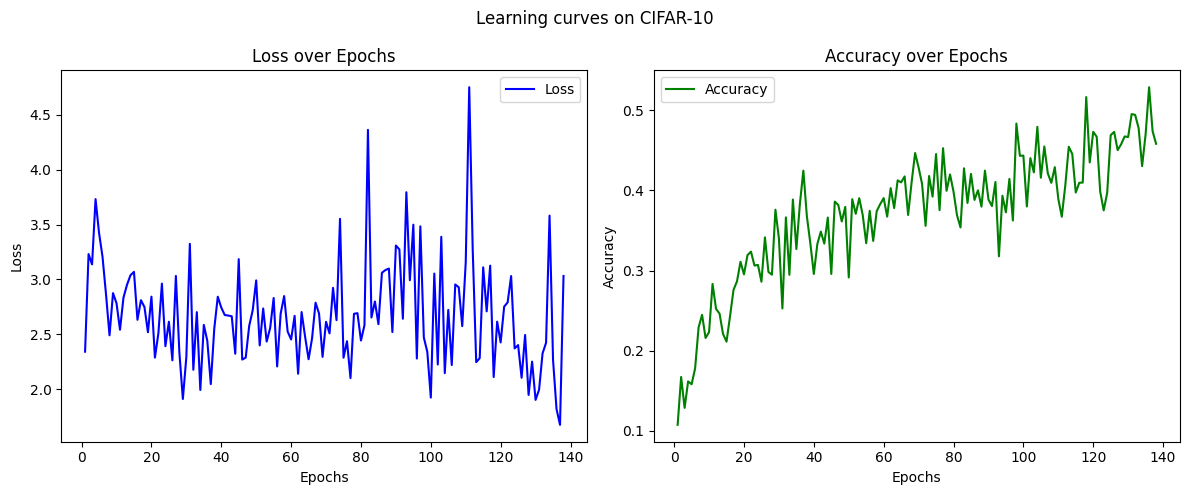

In [42]:
gc.collect()

losses, accuracies, elapsed = train_n_rounds_hybrid(
    pool_cifar,
    T_final=T_FINAL_MIN * 60,
    clients_per_round=math.ceil(len(pool_cifar.clients) * C),
    problem="cifar"
)

# save data
save_data(pool_cifar, losses, accuracies, elapsed, "hybrid_400_cifar")

plot_loss_accuracy(losses, accuracies, title="Learning curves on CIFAR-10")